In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_pipeline_diagram():
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')

    # Define node positions and sizes
    nodes = {
        "Input Image": {"pos": (5, 9), "shape": "box", "text": "Input Image\n(Degraded)"},
        "Pre-processing": {"pos": (5, 7.5), "shape": "box", "text": "Image Pre-processing\n(Optimized Parameters)"},
        "QR Detection": {"pos": (5, 6), "shape": "box", "text": "QR Code Detection\n(Pyzbar)"},
        "QR Decoding": {"pos": (5, 4.5), "shape": "box", "text": "QR Code Decoding\n(Pyzbar)"},
        "Output": {"pos": (5, 3), "shape": "box", "text": "Decoded Data\n& Metrics"},
        "Optimization (CS)": {"pos": (8, 6), "shape": "oval", "text": "Optimization\n(Cuckoo Search)"}
    }

    # Draw nodes
    for name, props in nodes.items():
        x, y = props["pos"]
        if props["shape"] == "box":
            rect = patches.Rectangle((x - 1.5, y - 0.5), 3, 1, linewidth=1, edgecolor='black', facecolor='lightgray', zorder=2)
            ax.add_patch(rect)
        elif props["shape"] == "oval":
            circ = patches.Ellipse((x, y), 3.5, 2, linewidth=1, edgecolor='black', facecolor='lightblue', zorder=2)
            ax.add_patch(circ)
        ax.text(x, y, props["text"], ha='center', va='center', fontsize=10, weight='bold', zorder=3)

    # Draw arrows
    # Main pipeline
    ax.annotate("", xy=(5, 8.5), xytext=(5, 9.5), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5))
    ax.annotate("", xy=(5, 7), xytext=(5, 8), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5))
    ax.annotate("", xy=(5, 5.5), xytext=(5, 6.5), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5))
    ax.annotate("", xy=(5, 4), xytext=(5, 5), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5))

    # Optimization loop
    ax.annotate("", xy=(6.5, 4.5), xytext=(6.5, 7.5), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, connectionstyle="arc3,rad=-0.3"), zorder=1) # From Decoding back to Pre-processing via Optimization
    ax.annotate("", xy=(8, 7), xytext=(8, 5), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), zorder=1) # To Optimization from somewhere (implicit feedback)
    ax.annotate("", xy=(6.5, 7.5), xytext=(8, 7.5), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), zorder=1) # Optimization output to Pre-processing parameters

    # Feedback from Decoding to Optimization (metrics for fitness)
    ax.annotate("", xy=(6.5, 4.5), xytext=(8, 4.5), arrowprops=dict(facecolor='black', shrink=0.05, width=0.5), zorder=1) # From Decoding to Optimization (for metrics)

    plt.title('Optimized QR Code Recognition and Decoding Pipeline')
    plt.show()

# You can call this function to see the conceptual diagram:
# draw_pipeline_diagram()

In [2]:
!ls /kaggle/input  # This is the location of the test images.

datasett  testmulti  ttestnew


In [3]:
!ls /kaggle/input/ttestnew/image  # Old dataset - Test images that contain 1 QR code in 1 image.

1.png  2.png  3.png  4.png  5.png  6.png


In [4]:
!ls /kaggle/input/testmulti/photo  # Newly added dataset - Test images that contain varying number of QR codes.

10.jpg	12.jpg	14.jpg	16.jpg	18.jpg	20.jpg	22.jpg	24.jpg	9.jpg
11.jpg	13.jpg	15.jpg	17.jpg	19.jpg	21.jpg	23.jpg	8.png


In [5]:
!ls -R /kaggle/input/datasett/

/kaggle/input/datasett/:
cd_project

/kaggle/input/datasett/cd_project:
image  label

/kaggle/input/datasett/cd_project/image:
100.jpg  126.jpg  151.jpg  177.jpg  201.jpg  227.jpg  26.jpg  51.jpg  77.jpg
101.jpg  127.jpg  152.jpg  178.jpg  202.jpg  228.jpg  27.jpg  52.jpg  78.jpg
102.jpg  128.jpg  153.jpg  179.jpg  203.jpg  229.jpg  28.jpg  53.jpg  79.jpg
103.jpg  129.jpg  154.jpg  17.jpg   204.jpg  22.jpg   29.jpg  54.jpg  7.jpg
104.jpg  12.jpg   155.jpg  180.jpg  205.jpg  230.jpg  2.jpg   55.jpg  80.jpg
105.jpg  130.jpg  156.jpg  181.jpg  206.jpg  231.jpg  30.jpg  56.jpg  81.jpg
106.jpg  131.jpg  157.jpg  182.jpg  207.jpg  232.jpg  31.jpg  57.jpg  82.jpg
107.jpg  132.jpg  158.jpg  183.jpg  208.jpg  233.jpg  32.jpg  58.jpg  83.jpg
108.jpg  133.jpg  159.jpg  184.jpg  209.jpg  234.jpg  33.jpg  59.jpg  84.jpg
109.jpg  134.jpg  15.jpg   185.jpg  20.jpg   235.jpg  34.jpg  5.jpg   85.jpg
10.jpg	 135.jpg  160.jpg  186.jpg  210.jpg  236.jpg  35.jpg  60.jpg  86.jpg
110.jpg  136.jpg  161.jpg  1

In [6]:
# Change to the working directory if not already there (Kaggle default)
import os
if os.getcwd() != '/kaggle/working':
    %cd /kaggle/working

# Clone the YOLOv7 repository
# This will create a 'yolov7' folder in '/kaggle/working/'
!git clone https://github.com/WongKinYiu/yolov7.git

# Change your current working directory INTO the yolov7 folder
# This is CRITICAL for all subsequent commands (train.py, detect.py, writing data/qr_code.yaml)
%cd yolov7

# Install the required Python packages from YOLOv7's requirements.txt
# This includes essential libraries like PyTorch, OpenCV, etc.
!pip install -r requirements.txt

# Install Weights & Biases for advanced logging and visualization of training metrics
!pip install wandb

# Install a compatible numpy version to resolve potential library conflicts (e.g., with jax or tensorflow)
# The '--no-deps' flag prevents reinstalling other packages that might conflict again.
!pip install numpy==1.26.4 --no-deps

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.29 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (511/511), done.
/kaggle/working/yolov7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 41.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.3 MB/s eta 0:00:0000:0100:01
  Att

In [7]:
import os
import wandb
from kaggle_secrets import UserSecretsClient

# 1. Instantiate the Kaggle Secrets client
user_secrets = UserSecretsClient()

# 2. Retrieve your WANDB_API_KEY secret
#    This will fetch the value you stored in Kaggle's "Add secret" feature
try:
    secret_value = user_secrets.get_secret("WANDB_API_KEY")
    # 3. Set the retrieved API key as an environment variable
    #    wandb.login() will then automatically pick this up
    os.environ["WANDB_API_KEY"] = secret_value
    print("WANDB_API_KEY successfully loaded from Kaggle Secrets.")
except Exception as e:
    print(f"Error loading WANDB_API_KEY from secrets: {e}")
    print("Please ensure you have created a secret named 'WANDB_API_KEY' in Kaggle and it's enabled.")

# 4. Now, attempt to log in with Weights & Biases
#    It should now use the environment variable we just set
wandb.login()

WANDB_API_KEY successfully loaded from Kaggle Secrets.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ishitaarana8 (ishitaarana8-amity-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
# Download the official YOLOv7 pre-trained weights
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

--2025-08-31 09:22:52--  https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/511187726/b0243edf-9fb0-4337-95e1-42555f1b37cf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-08-31T10%3A23%3A29Z&rscd=attachment%3B+filename%3Dyolov7.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-08-31T09%3A22%3A41Z&ske=2025-08-31T10%3A23%3A29Z&sks=b&skv=2018-11-09&sig=wWIaiu840v1ZkSSgRQx9AtBaFwR9HrFdrj5EDzr8LnY%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NjYzMjQ3MywibmJmIjoxNzU2NjMyMTczLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmUud2lu

In [9]:
import os
import shutil
import random # Needed for train/val splitting

# --- ADJUST THESE PA
# 1. Source path of your images and labels in Kaggle's input directory
#    Based on your description: /kaggle/input/cd-project-zip/cd_project/
source_root_path = '/kaggle/input/datasett/cd_project'
print(f"Accessing source dataset from: {source_root_path}")

# Full paths to your images and labels folders within the source
source_images_path = os.path.join(source_root_path, 'image') # Note: your folder is 'image', not 'images'
source_labels_path = os.path.join(source_root_path, 'label')  # Note: your folder is 'label', not 'labels'

# 2. Final destination path for your YOLOv7-structured dataset in your working directory
#    This is the directory you'll reference in your data/qr_code.yaml
final_data_dir = '/kaggle/working/datasets/qr_codes'
print(f"Targeting final YOLOv7 structure in: {final_data_dir}")
# --- END ADJUSTMENT ---

# --- 1. Prepare the final YOLOv7 directory structure ---
print(f"Creating final YOLOv7 structure in {final_data_dir}...")
os.makedirs(os.path.join(final_data_dir, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(final_data_dir, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(final_data_dir, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(final_data_dir, 'labels', 'val'), exist_ok=True)
print("Final YOLOv7 folder structure created.")

# --- 2. Perform Train/Validation Split and Copy Data ---
if not os.path.exists(source_images_path) or not os.path.exists(source_labels_path):
    print(f"ERROR: Source 'image' or 'label' subdirectories not found directly in {source_root_path}.")
    print("Please verify the exact paths and contents of your '/kaggle/input/cd-project-zip/cd_project/' folder.")
else:
    all_image_files = [f for f in os.listdir(source_images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(all_image_files) # Shuffle the list for random splitting

    # Define split ratio (e.g., 80% for training, 20% for validation)
    split_ratio = 0.8
    num_train = int(len(all_image_files) * split_ratio)

    train_files = all_image_files[:num_train]
    val_files = all_image_files[num_train:]

    print(f"Splitting dataset: {len(train_files)} training samples, {len(val_files)} validation samples.")

    # Copy train files to their destination
    for img_file in train_files:
        base_name = os.path.splitext(img_file)[0] # Get filename without extension
        label_file = base_name + '.txt' # Corresponding label file name

        shutil.copy(os.path.join(source_images_path, img_file),
                    os.path.join(final_data_dir, 'images', 'train', img_file))
        
        # Copy label file if it exists
        if os.path.exists(os.path.join(source_labels_path, label_file)):
            shutil.copy(os.path.join(source_labels_path, label_file),
                        os.path.join(final_data_dir, 'labels', 'train', label_file))
        else:
            print(f"Warning: Label file {label_file} not found for image {img_file}. Skipping label copy for this image.")

    # Copy validation files to their destination
    for img_file in val_files:
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        shutil.copy(os.path.join(source_images_path, img_file),
                    os.path.join(final_data_dir, 'images', 'val', img_file))
        
        # Copy label file if it exists
        if os.path.exists(os.path.join(source_labels_path, label_file)):
            shutil.copy(os.path.join(source_labels_path, label_file),
                        os.path.join(final_data_dir, 'labels', 'val', label_file))
        else:
            print(f"Warning: Label file {label_file} not found for image {img_file}. Skipping label copy for this image.")

    print("Dataset successfully copied, split, and moved to YOLOv7 structure.")

Accessing source dataset from: /kaggle/input/datasett/cd_project
Targeting final YOLOv7 structure in: /kaggle/working/datasets/qr_codes
Creating final YOLOv7 structure in /kaggle/working/datasets/qr_codes...
Final YOLOv7 folder structure created.
Splitting dataset: 200 training samples, 50 validation samples.
Dataset successfully copied, split, and moved to YOLOv7 structure.


In [10]:
%%writefile data/qr_code.yaml
# Train/Val/Test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2]
train: /kaggle/working/datasets/qr_codes/images/train
val: /kaggle/working/datasets/qr_codes/images/val

# Number of classes
nc: 1 # You have one class: QR code

# Class names
names: ['qr_code']

Writing data/qr_code.yaml


In [11]:
%pwd

'/kaggle/working/yolov7'

In [12]:
# Display lines around the error for inspection
# This will show lines 68 to 98 of train.py, with line numbers
!cat -n /kaggle/working/yolov7/train.py | head -n 98 | tail -n 30

    69	    if rank in [-1, 0]:
    70	        opt.hyp = hyp  # add hyperparameters
    71	        run_id = torch.load(weights, map_location=device).get('wandb_id') if weights.endswith('.pt') and os.path.isfile(weights) else None
    72	        wandb_logger = WandbLogger(opt, Path(opt.save_dir).stem, run_id, data_dict)
    73	        loggers['wandb'] = wandb_logger.wandb
    74	        data_dict = wandb_logger.data_dict
    75	        if wandb_logger.wandb:
    76	            weights, epochs, hyp = opt.weights, opt.epochs, opt.hyp  # WandbLogger might update weights, epochs if resuming
    77	
    78	    nc = 1 if opt.single_cls else int(data_dict['nc'])  # number of classes
    79	    names = ['item'] if opt.single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
    80	    assert len(names) == nc, '%g names found for nc=%g dataset in %s' % (len(names), nc, opt.data)  # check
    81	
    82	    # Model
    83	    pretrained = weights.endswith('.pt')
    84	  

In [13]:
import os

train_py_path = '/kaggle/working/yolov7/train.py'

# Read all lines from the file
with open(train_py_path, 'r') as f:
    lines = f.readlines()

modified = False
# Target the block where the problem is
# Line 87 should be indented 12 spaces (inside 'with' and 'if' block)
# Line 88 should also be indented 12 spaces
expected_indentation_L87 = "            " # 12 spaces
expected_indentation_L88 = "            " # 12 spaces

# Fix line 87
if len(lines) > 86: # Check if line 87 exists (index 86)
    line_87 = lines[86].lstrip() # Remove any existing leading whitespace
    if not line_87.startswith("ckpt = torch.load"): # Sanity check: ensure it's the line we expect
        print(f"Warning: Line 87 content unexpected: {lines[86].strip()}")
    else:
        new_line_87 = expected_indentation_L87 + line_87
        if lines[86] != new_line_87:
            lines[86] = new_line_87 + '\n' # Add newline back
            modified = True
            print(f"Corrected indentation for line 87.")
        else:
            print(f"Line 87 already correctly indented.")

# Fix line 88
if len(lines) > 87: # Check if line 88 exists (index 87)
    line_88 = lines[87].lstrip() # Remove any existing leading whitespace
    if not line_88.startswith("model = Model("): # Sanity check
        print(f"Warning: Line 88 content unexpected: {lines[87].strip()}")
    else:
        new_line_88 = expected_indentation_L88 + line_88
        if lines[87] != new_line_88:
            lines[87] = new_line_88 + '\n' # Add newline back
            modified = True
            print(f"Corrected indentation for line 88.")
        else:
            print(f"Line 88 already correctly indented.")

# Write the modified content back to the file
if modified:
    with open(train_py_path, 'w') as f:
        f.writelines(lines)
    print(f"Successfully fixed indentation in '{train_py_path}' on lines 87 and 88.")
else:
    print(f"No indentation changes were needed or made for lines 87 and 88.")

Corrected indentation for line 87.
Corrected indentation for line 88.
Successfully fixed indentation in '/kaggle/working/yolov7/train.py' on lines 87 and 88.


In [14]:
import os

# Define the path to train.py
train_py_path = '/kaggle/working/yolov7/train.py'

print(f"Attempting to patch '{train_py_path}' for PyTorch weights_only issue...")

lines = []
try:
    with open(train_py_path, 'r') as f:
        lines = f.readlines()
    print(f"Successfully read '{train_py_path}'.")
except FileNotFoundError:
    print(f"Error: '{train_py_path}' not found. Please ensure the path is correct.")
    exit()

modified = False
new_lines = []

for i, line in enumerate(lines):
    # Target the specific line that's causing the error (line 71 in traceback, so index 70)
    if i == 70: # Line number 71 is at index 70
        if "torch.load(weights, map_location=device)" in line and "weights_only=False" not in line:
            # Find the existing call and insert weights_only=False
            new_line = line.replace("torch.load(weights, map_location=device)",
                                    "torch.load(weights, map_location=device, weights_only=False)")
            new_lines.append(new_line)
            modified = True
            print(f"Patched line {i+1} in '{train_py_path}' to include 'weights_only=False'.")
        else:
            new_lines.append(line)
            print(f"Line {i+1} in '{train_py_path}' already contains 'weights_only=False' or is not the target line.")
    else:
        new_lines.append(line)

# Write the modified content back to the file
if modified:
    try:
        with open(train_py_path, 'w') as f:
            f.writelines(new_lines)
        print(f"Successfully applied the patch to '{train_py_path}'.")
    except Exception as e:
        print(f"Error writing to '{train_py_path}': {e}")
else:
    print(f"No changes were needed for '{train_py_path}' at line 71 regarding 'weights_only'.")

print("\nPatching attempt complete. Please try running train.py again.")

Attempting to patch '/kaggle/working/yolov7/train.py' for PyTorch weights_only issue...
Successfully read '/kaggle/working/yolov7/train.py'.
Patched line 71 in '/kaggle/working/yolov7/train.py' to include 'weights_only=False'.
Successfully applied the patch to '/kaggle/working/yolov7/train.py'.

Patching attempt complete. Please try running train.py again.


In [15]:
import os

# Define the path to train.py
train_py_path = '/kaggle/working/yolov7/train.py'

print(f"Attempting to patch '{train_py_path}' for all relevant PyTorch weights_only issues...")

lines = []
try:
    with open(train_py_path, 'r') as f:
        lines = f.readlines()
    print(f"Successfully read '{train_py_path}'.")
except FileNotFoundError:
    print(f"Error: '{train_py_path}' not found. Please ensure the path is correct.")
    exit()

modified = False
new_lines = []

for i, line in enumerate(lines):
    original_line = line.strip() # Get the line content without leading/trailing whitespace

    # Identify lines that load weights and don't already have 'weights_only=False'
    # This pattern covers both `torch.load(weights, map_location=device)`
    # and potentially other torch.load calls related to models/checkpoints.
    if "torch.load(" in original_line and ".pt" in original_line and "weights_only=False" not in original_line:
        # Check if 'map_location' is already present
        if "map_location=" in original_line:
            # Insert 'weights_only=False' before ')' if map_location is last arg
            # Or intelligently insert it if other args follow (less robust but usually fine)
            if original_line.endswith(')\n'): # Simple case: map_location is last arg
                new_line_content = original_line.replace(")", ", weights_only=False)")
            else: # More complex: assume it's somewhere in the middle or has other args
                # Find the closing parenthesis of the torch.load call and insert before it
                # This is a bit of a heuristic but often works for common patterns
                open_paren_idx = original_line.find("torch.load(")
                if open_paren_idx != -1:
                    # Find the corresponding closing parenthesis, accounting for nested ones if possible
                    # A more robust solution would be to parse Python AST. For simple cases, this is usually fine.
                    temp_slice = original_line[open_paren_idx + len("torch.load("):]
                    balance = 0
                    close_paren_idx_relative = -1
                    for k, char in enumerate(temp_slice):
                        if char == '(':
                            balance += 1
                        elif char == ')':
                            if balance == 0:
                                close_paren_idx_relative = k
                                break
                            balance -= 1
                    
                    if close_paren_idx_relative != -1:
                        insertion_point = open_paren_idx + len("torch.load(") + close_paren_idx_relative
                        new_line_content = original_line[:insertion_point] + ", weights_only=False" + original_line[insertion_point:]
                    else:
                        new_line_content = original_line.replace(")", ", weights_only=False)") # Fallback
                else:
                    new_line_content = original_line.replace(")", ", weights_only=False)") # Fallback


        else: # If map_location is not present, just add weights_only=False
            new_line_content = original_line.replace(")", ", weights_only=False)")
            
        # Retain original indentation
        original_indent = line[:len(line) - len(line.lstrip())]
        new_lines.append(original_indent + new_line_content + '\n')
        modified = True
        print(f"Patched line {i+1}: '{original_line}' -> '{new_line_content}' to include 'weights_only=False'.")
    else:
        new_lines.append(line)

# Write the modified content back to the file
if modified:
    try:
        with open(train_py_path, 'w') as f:
            f.writelines(new_lines)
        print(f"Successfully applied the patch to '{train_py_path}'.")
    except Exception as e:
        print(f"Error writing to '{train_py_path}': {e}")
else:
    print(f"No changes were needed for '{train_py_path}' regarding 'weights_only' in relevant torch.load calls.")

print("\nPatching attempt complete. Please try running train.py again.")

Attempting to patch '/kaggle/working/yolov7/train.py' for all relevant PyTorch weights_only issues...
Successfully read '/kaggle/working/yolov7/train.py'.
No changes were needed for '/kaggle/working/yolov7/train.py' regarding 'weights_only' in relevant torch.load calls.

Patching attempt complete. Please try running train.py again.


In [16]:
%cd /kaggle/working/yolov7
!cat -n train.py | head -n 100 # Check first 100 lines for the changes

/kaggle/working/yolov7
     1	import argparse
     2	import logging
     3	import math
     4	import os
     5	import random
     6	import time
     7	from copy import deepcopy
     8	from pathlib import Path
     9	from threading import Thread
    10	
    11	import numpy as np
    12	import torch.distributed as dist
    13	import torch.nn as nn
    14	import torch.nn.functional as F
    15	import torch.optim as optim
    16	import torch.optim.lr_scheduler as lr_scheduler
    17	import torch.utils.data
    18	import yaml
    19	from torch.cuda import amp
    20	from torch.nn.parallel import DistributedDataParallel as DDP
    21	from torch.utils.tensorboard import SummaryWriter
    22	from tqdm import tqdm
    23	
    24	import test  # import test.py to get mAP after each epoch
    25	from models.experimental import attempt_load
    26	from models.yolo import Model
    27	from utils.autoanchor import check_anchors
    28	from utils.datasets import create_dataloader
    29	from utils.gen

In [17]:
import os

# Define the path to train.py
train_py_path = '/kaggle/working/yolov7/train.py'

print(f"Attempting to patch '{train_py_path}' specifically for line 87...")

lines = []
try:
    with open(train_py_path, 'r') as f:
        lines = f.readlines()
    print(f"Successfully read '{train_py_path}'.")
except FileNotFoundError:
    print(f"Error: '{train_py_path}' not found. Please ensure the path is correct.")
    exit()

modified = False
new_lines = []

# Target line 87 (index 86 in a 0-indexed list)
target_line_index = 86

if len(lines) > target_line_index:
    line_to_patch = lines[target_line_index]
    
    # Check if the line is what we expect and doesn't already have the patch
    if "ckpt = torch.load(weights, map_location=device)" in line_to_patch and "weights_only=False" not in line_to_patch:
        # Preserve leading whitespace (indentation)
        leading_spaces = line_to_patch[:len(line_to_patch) - len(line_to_patch.lstrip())]
        
        # Modify the line content
        # Insert ', weights_only=False' before the closing parenthesis and comment
        modified_line_content = line_to_patch.replace(
            "torch.load(weights, map_location=device)",
            "torch.load(weights, map_location=device, weights_only=False)"
        )
        
        new_lines = list(lines) # Create a mutable copy
        new_lines[target_line_index] = modified_line_content
        modified = True
        print(f"Patched line {target_line_index + 1} in '{train_py_path}'.")
    else:
        print(f"Line {target_line_index + 1} in '{train_py_path}' is already patched or not the expected content.")
        new_lines = lines # No change needed, keep original lines

else:
    print(f"Error: '{train_py_path}' does not have a line {target_line_index + 1}. Skipping patch.")
    new_lines = lines # No change needed, keep original lines


# Write the modified content back to the file if changes were made
if modified:
    try:
        with open(train_py_path, 'w') as f:
            f.writelines(new_lines)
        print(f"Successfully applied the patch to '{train_py_path}'.")
    except Exception as e:
        print(f"Error writing to '{train_py_path}': {e}")
else:
    print(f"No changes were needed for '{train_py_path}' at line {target_line_index + 1}.")

print("\nPatching attempt complete. Please try running train.py again.")

# Verify the patch (optional, but highly recommended)
%cd /kaggle/working/yolov7
!cat -n train.py | head -n 100

Attempting to patch '/kaggle/working/yolov7/train.py' specifically for line 87...
Successfully read '/kaggle/working/yolov7/train.py'.
Patched line 87 in '/kaggle/working/yolov7/train.py'.
Successfully applied the patch to '/kaggle/working/yolov7/train.py'.

Patching attempt complete. Please try running train.py again.
/kaggle/working/yolov7
     1	import argparse
     2	import logging
     3	import math
     4	import os
     5	import random
     6	import time
     7	from copy import deepcopy
     8	from pathlib import Path
     9	from threading import Thread
    10	
    11	import numpy as np
    12	import torch.distributed as dist
    13	import torch.nn as nn
    14	import torch.nn.functional as F
    15	import torch.optim as optim
    16	import torch.optim.lr_scheduler as lr_scheduler
    17	import torch.utils.data
    18	import yaml
    19	from torch.cuda import amp
    20	from torch.nn.parallel import DistributedDataParallel as DDP
    21	from torch.utils.tensorboard import Summary

In [18]:
import os

# Define the path to utils/general.py
general_py_path = '/kaggle/working/yolov7/utils/general.py'

print(f"Attempting to patch '{general_py_path}' for weights_only issue in strip_optimizer...")

lines = []
try:
    with open(general_py_path, 'r') as f:
        lines = f.readlines()
    print(f"Successfully read '{general_py_path}'.")
except FileNotFoundError:
    print(f"Error: '{general_py_path}' not found. Please ensure the path is correct.")
    exit()

modified = False
new_lines = []

# Target line 802 (index 801 in a 0-indexed list)
target_line_index = 801

if len(lines) > target_line_index:
    line_to_patch = lines[target_line_index]
    
    # Check if the line is what we expect and doesn't already have the patch
    if "x = torch.load(f, map_location=torch.device('cpu'))" in line_to_patch and "weights_only=False" not in line_to_patch:
        # Preserve leading whitespace (indentation)
        leading_spaces = line_to_patch[:len(line_to_patch) - len(line_to_patch.lstrip())]
        
        # Modify the line content
        modified_line_content = line_to_patch.replace(
            "torch.load(f, map_location=torch.device('cpu'))",
            "torch.load(f, map_location=torch.device('cpu'), weights_only=False)"
        )
        
        new_lines = list(lines) # Create a mutable copy
        new_lines[target_line_index] = modified_line_content
        modified = True
        print(f"Patched line {target_line_index + 1} in '{general_py_path}'.")
    else:
        print(f"Line {target_line_index + 1} in '{general_py_path}' is already patched or not the expected content.")
        new_lines = lines # No change needed, keep original lines

else:
    print(f"Error: '{general_py_path}' does not have a line {target_line_index + 1}. Skipping patch.")
    new_lines = lines # No change needed, keep original lines


# Write the modified content back to the file if changes were made
if modified:
    try:
        with open(general_py_path, 'w') as f:
            f.writelines(new_lines)
        print(f"Successfully applied the patch to '{general_py_path}'.")
    except Exception as e:
        print(f"Error writing to '{general_py_path}': {e}")
else:
    print(f"No changes were needed for '{general_py_path}' at line {target_line_index + 1}.")

print("\nPatching attempt complete. Please try running train.py again.")

# Verify the patch (optional, but highly recommended)
%cd /kaggle/working/yolov7/utils
!cat -n general.py | tail -n +790 | head -n 20 # Check around line 802

Attempting to patch '/kaggle/working/yolov7/utils/general.py' for weights_only issue in strip_optimizer...
Successfully read '/kaggle/working/yolov7/utils/general.py'.
Patched line 802 in '/kaggle/working/yolov7/utils/general.py'.
Successfully applied the patch to '/kaggle/working/yolov7/utils/general.py'.

Patching attempt complete. Please try running train.py again.
/kaggle/working/yolov7/utils
   790	                i = i[iou.sum(1) > 1]  # require redundancy
   791	
   792	        output[xi] = x[i]
   793	        if (time.time() - t) > time_limit:
   794	            print(f'WARNING: NMS time limit {time_limit}s exceeded')
   795	            break  # time limit exceeded
   796	
   797	    return output
   798	
   799	
   800	def strip_optimizer(f='best.pt', s=''):  # from utils.general import *; strip_optimizer()
   801	    # Strip optimizer from 'f' to finalize training, optionally save as 's'
   802	    x = torch.load(f, map_location=torch.device('cpu'), weights_only=False)
   803

In [19]:
# Ensure you are in the yolov7 directory
%cd /kaggle/working/yolov7

# Define the content for your custom data.yaml with absolute paths
data_yaml_content = """
# train, val sets (absolute paths)
train: /kaggle/working/datasets/qr_codes/images/train/
val: /kaggle/working/datasets/qr_codes/images/val/
# test: /kaggle/working/datasets/qr_codes/images/test/ # Uncomment if you have a test set

# number of classes
nc: 1

# class names
names: ['qr_code']
"""

# Write the content to a new file in the data/ directory
with open('data/qr_code_data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("data/qr_code_data.yaml created successfully with absolute paths.")
print("Contents:")
!cat data/qr_code_data.yaml

/kaggle/working/yolov7
data/qr_code_data.yaml created successfully with absolute paths.
Contents:

# train, val sets (absolute paths)
train: /kaggle/working/datasets/qr_codes/images/train/
val: /kaggle/working/datasets/qr_codes/images/val/
# test: /kaggle/working/datasets/qr_codes/images/test/ # Uncomment if you have a test set

# number of classes
nc: 1

# class names
names: ['qr_code']


In [20]:
import os

# Define the path to utils/datasets.py
datasets_py_path = '/kaggle/working/yolov7/utils/datasets.py'

print(f"Attempting to patch '{datasets_py_path}' for weights_only issue in cache loading...")

lines = []
try:
    with open(datasets_py_path, 'r') as f:
        lines = f.readlines()
    print(f"Successfully read '{datasets_py_path}'.")
except FileNotFoundError:
    print(f"Error: '{datasets_py_path}' not found. Please ensure the path is correct.")
    exit()

modified = False
new_lines = []

# Target line 392 (index 391 in a 0-indexed list)
target_line_index = 391

if len(lines) > target_line_index:
    line_to_patch = lines[target_line_index]
    
    # Check if the line is what we expect and doesn't already have the patch
    if "cache, exists = torch.load(cache_path)" in line_to_patch and "weights_only=False" not in line_to_patch:
        # Preserve leading whitespace (indentation)
        leading_spaces = line_to_patch[:len(line_to_patch) - len(line_to_patch.lstrip())]
        
        # Modify the line content
        # Insert ', weights_only=False' before the closing parenthesis and potentially comment/other assignments
        modified_line_content = line_to_patch.replace(
            "torch.load(cache_path)",
            "torch.load(cache_path, weights_only=False)"
        )
        
        new_lines = list(lines) # Create a mutable copy
        new_lines[target_line_index] = modified_line_content
        modified = True
        print(f"Patched line {target_line_index + 1} in '{datasets_py_path}'.")
    else:
        print(f"Line {target_line_index + 1} in '{datasets_py_path}' is already patched or not the expected content.")
        new_lines = lines # No change needed, keep original lines

else:
    print(f"Error: '{datasets_py_path}' does not have a line {target_line_index + 1}. Skipping patch.")
    new_lines = lines # No change needed, keep original lines


# Write the modified content back to the file if changes were made
if modified:
    try:
        with open(datasets_py_path, 'w') as f:
            f.writelines(new_lines)
        print(f"Successfully applied the patch to '{datasets_py_path}'.")
    except Exception as e:
        print(f"Error writing to '{datasets_py_path}': {e}")
else:
    print(f"No changes were needed for '{datasets_py_path}' at line {target_line_index + 1}.")

print("\nPatching attempt complete. Please try running train.py again.")

# Verify the patch (optional, but highly recommended)
%cd /kaggle/working/yolov7/utils
!cat -n datasets.py | tail -n +380 | head -n 20 # Check around line 392

Attempting to patch '/kaggle/working/yolov7/utils/datasets.py' for weights_only issue in cache loading...
Successfully read '/kaggle/working/yolov7/utils/datasets.py'.
Patched line 392 in '/kaggle/working/yolov7/utils/datasets.py'.
Successfully applied the patch to '/kaggle/working/yolov7/utils/datasets.py'.

Patching attempt complete. Please try running train.py again.
/kaggle/working/yolov7/utils
   380	                else:
   381	                    raise Exception(f'{prefix}{p} does not exist')
   382	            self.img_files = sorted([x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in img_formats])
   383	            # self.img_files = sorted([x for x in f if x.suffix[1:].lower() in img_formats])  # pathlib
   384	            assert self.img_files, f'{prefix}No images found'
   385	        except Exception as e:
   386	            raise Exception(f'{prefix}Error loading data from {path}: {e}\nSee {help_url}')
   387	
   388	        # Check cache
   389	        sel

In [21]:
%cd /kaggle/working/yolov7

!python train.py \
    --workers 4 \
    --device 0 \
    --batch-size 2 \
    --epochs 30 \
    --img-size 640 \
    --data data/qr_code_data.yaml \
    --cfg cfg/training/yolov7.yaml \
    --weights yolov7.pt \
    --name yolov7_qr_code_training_run_2004 \
    --hyp data/hyp.scratch.p5.yaml

/kaggle/working/yolov7
2025-08-31 09:40:09.643112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756633209.840263     154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756633209.900289     154 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: ishitaarana8 (ishitaarana8-amity-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/yolov7/wandb/run-20250831_094027-oyg4s9cn
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run yolov7_qr_code_training_run_2004
wandb: ⭐️ View project at ht

In [22]:
import os

# Define the path to detect.py
detect_py_path = '/kaggle/working/yolov7/detect.py'

print(f"Attempting to patch '{detect_py_path}' for weights_only issue...")

lines = []
try:
    with open(detect_py_path, 'r') as f:
        lines = f.readlines()
    print(f"Successfully read '{detect_py_path}'.")
except FileNotFoundError:
    print(f"Error: '{detect_py_path}' not found. Please ensure the path is correct.")
    exit()

modified = False
new_lines = []

# Target the line containing 'model = attempt_load(weights, map_location=device)'
# We will modify the 'attempt_load' function call itself, or the underlying 'torch.load' within it.
# The error message points to line 34 in detect.py which calls attempt_load.
# Let's directly patch attempt_load in models/experimental.py for robustness,
# as that's where the actual torch.load is.

# Define the path to models/experimental.py
experimental_py_path = '/kaggle/working/yolov7/models/experimental.py'
print(f"Attempting to patch '{experimental_py_path}' for weights_only issue...")

exp_lines = []
try:
    with open(experimental_py_path, 'r') as f:
        exp_lines = f.readlines()
    print(f"Successfully read '{experimental_py_path}'.")
except FileNotFoundError:
    print(f"Error: '{experimental_py_path}' not found. Please ensure the path is correct.")
    exit()

exp_modified = False
new_exp_lines = []

# Find the torch.load call in models/experimental.py
# The error traceback points to line 252 in experimental.py
target_exp_line_index = 251 # 0-indexed for line 252

if len(exp_lines) > target_exp_line_index:
    line_to_patch = exp_lines[target_exp_line_index]
    
    # Check if the line is what we expect and doesn't already have the patch
    if "ckpt = torch.load(w, map_location=map_location)" in line_to_patch and "weights_only=False" not in line_to_patch:
        # Preserve leading whitespace (indentation)
        leading_spaces = line_to_patch[:len(line_to_patch) - len(line_to_patch.lstrip())]
        
        # Modify the line content
        modified_line_content = line_to_patch.replace(
            "torch.load(w, map_location=map_location)",
            "torch.load(w, map_location=map_location, weights_only=False)"
        )
        
        new_exp_lines = list(exp_lines) # Create a mutable copy
        new_exp_lines[target_exp_line_index] = modified_line_content
        exp_modified = True
        print(f"Patched line {target_exp_line_index + 1} in '{experimental_py_path}'.")
    else:
        print(f"Line {target_exp_line_index + 1} in '{experimental_py_path}' is already patched or not the expected content.")
        new_exp_lines = exp_lines # No change needed

else:
    print(f"Error: '{experimental_py_path}' does not have a line {target_exp_line_index + 1}. Skipping patch.")
    new_exp_lines = exp_lines # No change needed

# Write the modified content back to the file if changes were made
if exp_modified:
    try:
        with open(experimental_py_path, 'w') as f:
            f.writelines(new_exp_lines)
        print(f"Successfully applied the patch to '{experimental_py_path}'.")
    except Exception as e:
        print(f"Error writing to '{experimental_py_path}': {e}")
else:
    print(f"No changes were needed for '{experimental_py_path}' at line {target_exp_line_index + 1}.")

print("\nPatching attempt complete for detect.py dependencies. Please try running detect.py again.")

# Verify the patch (optional, but highly recommended)
%cd /kaggle/working/yolov7/models
!cat -n experimental.py | tail -n +240 | head -n 20 # Check around line 252

Attempting to patch '/kaggle/working/yolov7/detect.py' for weights_only issue...
Successfully read '/kaggle/working/yolov7/detect.py'.
Attempting to patch '/kaggle/working/yolov7/models/experimental.py' for weights_only issue...
Successfully read '/kaggle/working/yolov7/models/experimental.py'.
Patched line 252 in '/kaggle/working/yolov7/models/experimental.py'.
Successfully applied the patch to '/kaggle/working/yolov7/models/experimental.py'.

Patching attempt complete for detect.py dependencies. Please try running detect.py again.
/kaggle/working/yolov7/models
   240	        x = self.end2end(x)
   241	        return x
   242	
   243	
   244	
   245	
   246	
   247	def attempt_load(weights, map_location=None):
   248	    # Loads an ensemble of models weights=[a,b,c] or a single model weights=[a] or weights=a
   249	    model = Ensemble()
   250	    for w in weights if isinstance(weights, list) else [weights]:
   251	        attempt_download(w)
   252	        ckpt = torch.load(w, map_l

In [23]:
# First, change to the yolov7 directory
%cd /kaggle/working/yolov7

# Define the path to your trained weights
trained_weights_path = 'runs/train/yolov7_qr_code_training_run_500/weights/best.pt'

print(f"Running inference using weights: {trained_weights_path}")

# --- Run detection on the OLD dataset (1 QR code per image) ---
single_qr_test_image_dir = '/kaggle/input/ttestnew/image' # Test images with 1 QR code in 1 image.
single_qr_output_name = 'qr_code_detection_results_single_qr'

print(f"\n--- Detecting on images from: {single_qr_test_image_dir} ---")
!python detect.py \
    --weights {trained_weights_path} \
    --source {single_qr_test_image_dir} \
    --img-size 640 \
    --conf 0.25 \
    --name {single_qr_output_name} \
    --save-txt \
    --save-conf \
    --device 0 # Use GPU if available

print(f"\nDetection complete for single QR dataset. Check the 'runs/detect/{single_qr_output_name}' directory for results.")

# --- Run detection on the NEWLY ADDED dataset (varying number of QR codes) ---
multi_qr_test_image_dir = '/kaggle/input/testmulti/photo/' # Test images that contain varying number of QR codes.
multi_qr_output_name = 'qr_code_detection_results_multi_qr'

print(f"\n--- Detecting on images from: {multi_qr_test_image_dir} ---")
!python detect.py \
    --weights {trained_weights_path} \
    --source {multi_qr_test_image_dir} \
    --img-size 640 \
    --conf 0.25 \
    --name {multi_qr_output_name} \
    --save-txt \
    --save-conf \
    --device 0 # Use GPU if available

print(f"\nDetection complete for multi QR dataset. Check the 'runs/detect/{multi_qr_output_name}' directory for results.")

/kaggle/working/yolov7
Running inference using weights: runs/train/yolov7_qr_code_training_run_500/weights/best.pt

--- Detecting on images from: /kaggle/input/ttestnew/image ---
Namespace(weights=['runs/train/yolov7_qr_code_training_run_500/weights/best.pt'], source='/kaggle/input/ttestnew/image', img_size=640, conf_thres=0.25, iou_thres=0.45, device='0', view_img=False, save_txt=True, save_conf=True, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='qr_code_detection_results_single_qr', exist_ok=False, no_trace=False)
Traceback (most recent call last):
  File "/kaggle/working/yolov7/detect.py", line 196, in <module>
    detect()
  File "/kaggle/working/yolov7/detect.py", line 34, in detect
    model = attempt_load(weights, map_location=device)  # load FP32 model
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/kaggle/working/yolov7/models/experimental.py", line 252, in attempt_load
    ckpt = torch.load(w, map_loc

In [24]:
print("Ensuring pyzbar and OpenCV Python libraries are installed...")
!apt-get update -qq # Update package lists quietly
!apt-get install -y libzbar0 # Install zbar shared library
!pip install pyzbar opencv-python-headless # headless version for Kaggle
print("Libraries check complete.")

Ensuring pyzbar and OpenCV Python libraries are installed...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libv4l-0 libv4lconvert0
The following NEW packages will be installed:
  libv4l-0 libv4lconvert0 libzbar0
0 upgraded, 3 newly installed, 0 to remove and 268 not upgraded.
Need to get 248 kB of archives.
After this operation, 831 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libv4lconvert0 amd64 1.22.1-2build1 [82.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libv4l-0 amd64 1.22.1-2build1 [44.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libzbar0 amd64 0.23.92-4build2 [121 kB]
Fetched 248 kB in 2s (148 kB/s

In [25]:
import os
import glob
from PIL import Image
from pyzbar.pyzbar import decode
import cv2 # OpenCV for image manipulation
import numpy as np # For font scaling

# Define the base directory where YOLOv7 detection results are saved
yolov7_runs_detect_base_dir = '/kaggle/working/yolov7/runs/detect'

# Define the specific detection result directories for each dataset
detection_result_dirs = {
    'single_qr': os.path.join(yolov7_runs_detect_base_dir, 'qr_code_detection_results_single_qr'), # Results from old dataset
    'multi_qr': os.path.join(yolov7_runs_detect_base_dir, 'qr_code_detection_results_multi_qr')   # Results from new dataset
}

print("Starting QR code decoding and visualization for detected images from both datasets...")

for dataset_name, detection_results_dir in detection_result_dirs.items():
    # Define a new directory to save the visualized results for the current dataset
    output_visualization_dir = os.path.join(yolov7_runs_detect_base_dir, f'qr_code_decoded_visualizations_{dataset_name}')
    os.makedirs(output_visualization_dir, exist_ok=True)
    print(f"\n--- Processing results for: {dataset_name.replace('_', ' ').upper()} dataset ---")
    print(f"Input detection results from: {detection_results_dir}")
    print(f"Visualized results will be saved to: {output_visualization_dir}")

    # Check if the detection results directory exists and list its contents
    if not os.path.isdir(detection_results_dir):
        print(f"Warning: Detection results directory '{detection_results_dir}' not found. Skipping {dataset_name}. Please ensure YOLOv7 detection ran successfully for this dataset.")
        continue

    print(f"\nListing contents of input directory: {detection_results_dir}")
    # Using os.listdir instead of !ls for robustness within a Python script
    try:
        print(os.listdir(detection_results_dir))
    except FileNotFoundError:
        print("Directory not found or accessible.")


    # Get a list of all detected image files (e.g., .jpg, .png)
    image_files = sorted(glob.glob(os.path.join(detection_results_dir, '*.jpg'))) + \
                  sorted(glob.glob(os.path.join(detection_results_dir, '*.png')))


    if not image_files:
        print(f"No image files found in {detection_results_dir}. This might mean no QR codes were detected or the directory is empty.")
    else:
        for image_path in image_files:
            original_image_name = os.path.basename(image_path)
            output_image_path = os.path.join(output_visualization_dir, original_image_name)

            print(f"\nProcessing image: {original_image_name}")

            try:
                # Load the image using OpenCV
                img = cv2.imread(image_path)

                # Check if image loaded successfully
                if img is None:
                    print(f"Error: Could not load image {image_path}. Skipping.")
                    continue

                # Decode QR codes from the image
                decoded_objects = decode(img)

                if decoded_objects:
                    for obj in decoded_objects:
                        decoded_data = obj.data.decode('utf-8')
                        print(f"  Decoded Data: {decoded_data}")
                        print(f"  Type: {obj.type}")

                        # Get bounding box coordinates
                        (x, y, w, h) = obj.rect

                        # Draw bounding box
                        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green box

                        # Define text properties
                        text = decoded_data
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        font_scale = 0.7
                        font_thickness = 2
                        text_color = (0, 0, 255) # Red color for text

                        # Calculate text size to place it nicely
                        (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)

                        # Position the text slightly above the bounding box
                        text_x = x
                        text_y = y - 10 if y - 10 > text_height else y + text_height + 10 # Adjust if too close to top

                        # Put the text on the image
                        cv2.putText(img, text, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

                    # Save the image with visualizations
                    cv2.imwrite(output_image_path, img)
                    print(f"  Saved visualized image to: {output_image_path}")

                else:
                    print("  No QR code decoded by pyzbar (even if YOLOv7 detected something).")
                    # If no QR code was decoded, still save the original detected image to the output folder
                    # so we have a record, but without the text overlay.
                    cv2.imwrite(output_image_path, img)
                    print(f"  Saved original detected image (no text overlay) to: {output_image_path}")

            except Exception as e:
                print(f"An error occurred while processing {image_path}: {e}")

print("\n--- All QR code decoding and visualization processes complete. ---")
print(f"You can view the results in subdirectories within '{yolov7_runs_detect_base_dir}', specifically 'qr_code_decoded_visualizations_single_qr' and 'qr_code_decoded_visualizations_multi_qr'.")

Starting QR code decoding and visualization for detected images from both datasets...

--- Processing results for: SINGLE QR dataset ---
Input detection results from: /kaggle/working/yolov7/runs/detect/qr_code_detection_results_single_qr
Visualized results will be saved to: /kaggle/working/yolov7/runs/detect/qr_code_decoded_visualizations_single_qr

Listing contents of input directory: /kaggle/working/yolov7/runs/detect/qr_code_detection_results_single_qr
['labels']
No image files found in /kaggle/working/yolov7/runs/detect/qr_code_detection_results_single_qr. This might mean no QR codes were detected or the directory is empty.

--- Processing results for: MULTI QR dataset ---
Input detection results from: /kaggle/working/yolov7/runs/detect/qr_code_detection_results_multi_qr
Visualized results will be saved to: /kaggle/working/yolov7/runs/detect/qr_code_decoded_visualizations_multi_qr

Listing contents of input directory: /kaggle/working/yolov7/runs/detect/qr_code_detection_results_mul

Weights & Biases initialized successfully.
Total images found for Fopt evaluation: 23
Assumed TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION: 23

--- Running Cuckoo Search for Image Pre-processing Optimization (using adapted Fopt) ---
Evaluating initial population...


	i=4 f=-1(000) part=0
	i=18 f=-1(000) part=0
	i=18 f=-1(000) part=0
	i=24 f=-1(000) part=0
	i=18 f=-1(000) part=0
	i=23 f=-1(000) part=0
	i=23 f=-1(000) part=0
	i=24 f=-1(000) part=0


  [Fopt Objective] Params=[  4.     0.85 -60.  ], DA=30.43%, FPS=3.80, MR=69.57%, Fopt=-3.9675
  [Fopt Objective] Params=[ 8.    2.83 45.  ], DA=69.57%, FPS=5.97, MR=30.43%, Fopt=54.9444
  [Fopt Objective] Params=[ 5.    0.81 35.  ], DA=173.91%, FPS=4.24, MR=-73.91%, Fopt=211.2939
  [Fopt Objective] Params=[ 9.    1.04 16.  ], DA=191.30%, FPS=4.82, MR=-91.30%, Fopt=237.4385
  [Fopt Objective] Params=[ 5.    1.31 -2.  ], DA=173.91%, FPS=4.16, MR=-73.91%, Fopt=211.2855
  [Fopt Objective] Params=[  2.     1.74 -56.  ], DA=139.13%, FPS=3.89, MR=-39.13%, Fopt=159.0847
  [Fopt Objective] Params=[8.   2.42 1.  ], DA=143.48%, FPS=5.31, MR=-43.48%, Fopt=165.7479
  [Fopt Objective] Params=[10.    1.75 55.  ], DA=178.26%, FPS=5.65, MR=-78.26%, Fopt=217.9562
  [Fopt Objective] Params=[ 8.    1.08 51.  ], DA=200.00%, FPS=4.98, MR=-100.00%, Fopt=250.4977
  [Fopt Objective] Params=[3.  1.3 4. ], DA=160.87%, FPS=3.93, MR=-60.87%, Fopt=191.6977

Starting Cuckoo Search Optimization...
  [Fopt Objective]

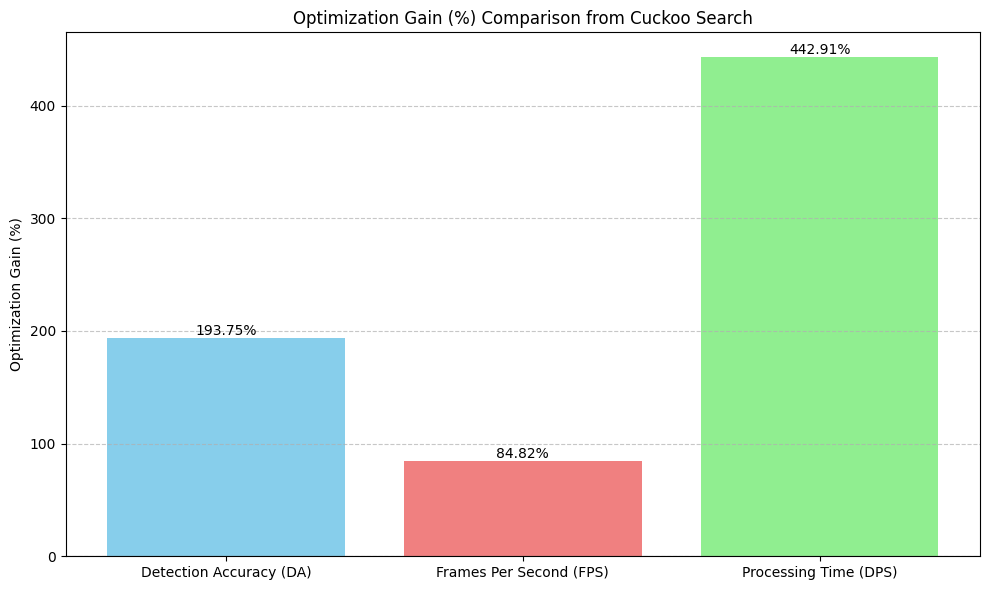


--- Generating Simplified Confusion Matrix Heatmap ---


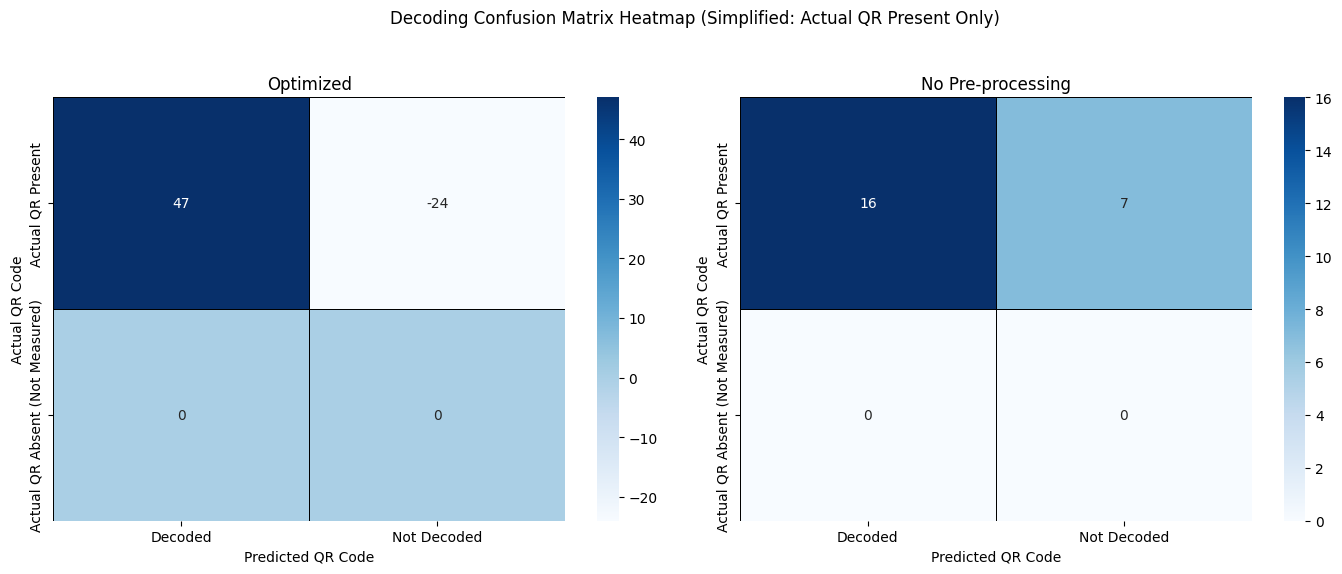


--- Attempting to generate Processing Time/FPS vs. Number of QR Codes Charts ---
NOTE: This requires knowledge of the EXACT number of QR codes in each image of the 'testmulti' dataset.
Please populate 'multi_qr_image_counts_gt' with the actual QR counts for your images for accurate plots.



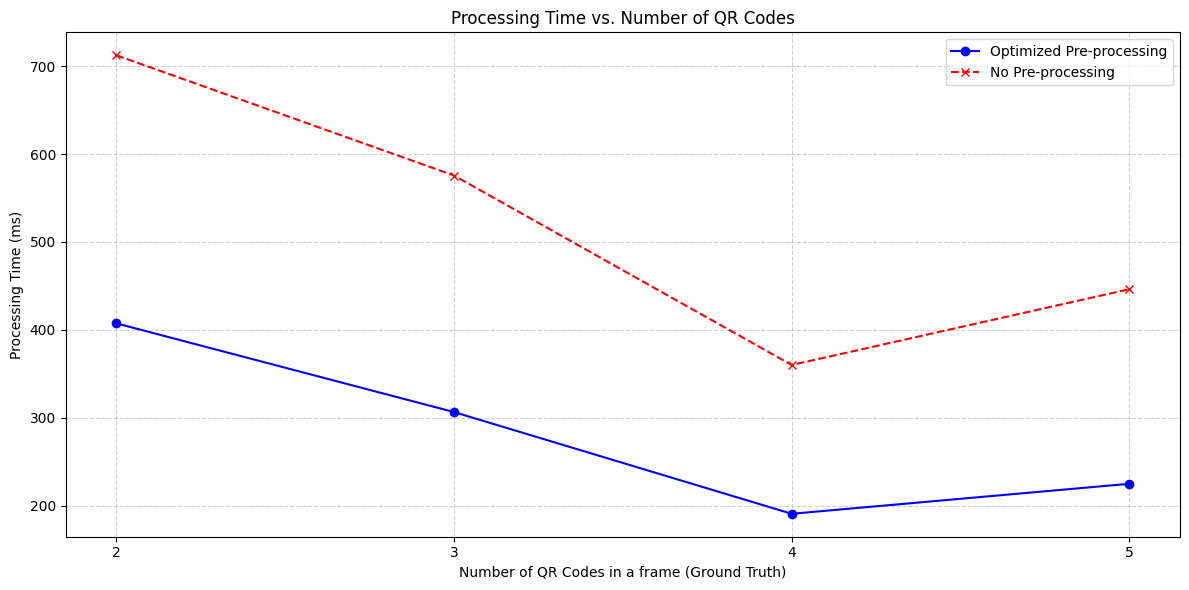

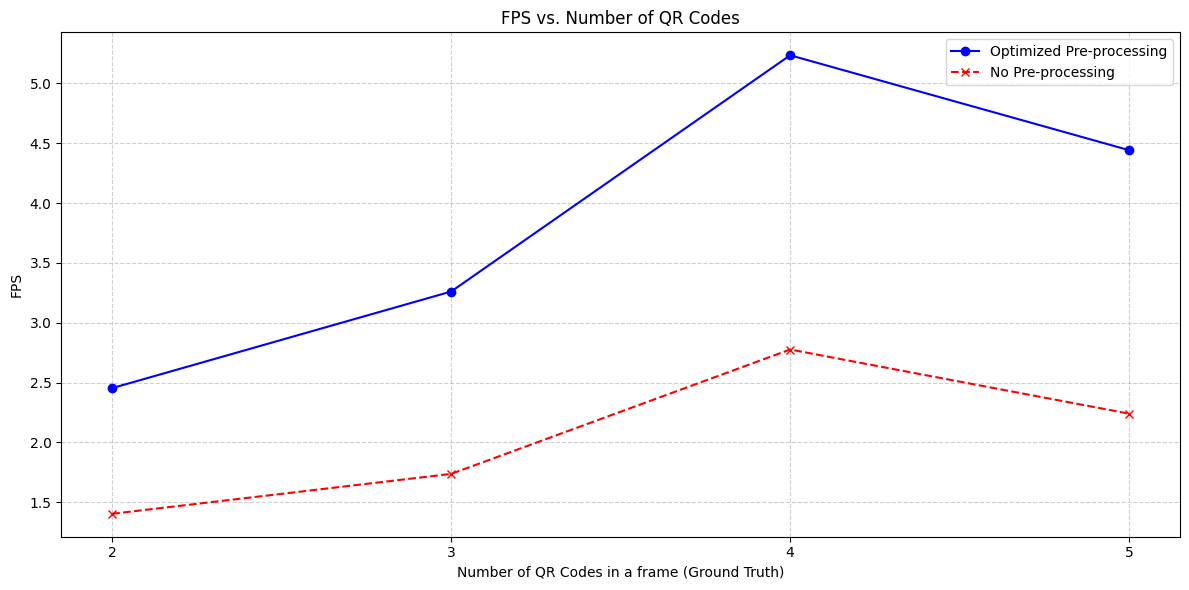


All performance metrics calculated and charts generated.


CS_Best_Fopt_Value,▁██████████████
CS_Initial_Best_Fopt,▁
CS_Iteration,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Final_Metrics/NoOpt_DA_percent,▁
Final_Metrics/NoOpt_DPS,▁
Final_Metrics/NoOpt_FPS,▁
Final_Metrics/NoOpt_MR_percent,▁
Final_Metrics/OG_DA_percent,▁
Final_Metrics/OG_DPS_percent,▁
Final_Metrics/OG_FPS_percent,▁
Final_Metrics/Optimized_DA_percent,▁


In [26]:
import numpy as np
import cv2
from pyzbar import pyzbar
import os
import glob
import time
import matplotlib.pyplot as plt
import pandas as pd # For tabular output
import seaborn as sns # For heatmap
import wandb # Assuming W&B is still desired

# --- W&B Setup ---
try:
    wandb.login()
    wandb.init(project="QR_Code_Decoding_Optimization", name="Cuckoo_Search_Fopt_Evaluation")
    print("Weights & Biases initialized successfully.")
except Exception as e:
    print(f"Warning: Could not initialize Weights & Biases. Error: {e}")
    print("Metrics will only be printed to console.")
    class DummyWandB:
        def log(self, *args, **kwargs): pass
        def finish(self): pass
        config = {}
    wandb = DummyWandB()

# --- Pre-processing Function (Reusable) ---
def apply_preprocessing(image, blur_kernel_size, contrast_alpha, brightness_beta):
    """Applies pre-processing steps to an image."""
    processed_image = image.copy()

    # Grayscale conversion
    if len(processed_image.shape) == 3:
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)

    # Ensure kernel size is odd and positive for Gaussian blur
    blur_kernel_size = int(round(blur_kernel_size))
    if blur_kernel_size % 2 == 0:
        blur_kernel_size += 1
    blur_kernel_size = max(1, blur_kernel_size)

    # Gaussian Blur
    if blur_kernel_size > 0:
        processed_image = cv2.GaussianBlur(processed_image, (blur_kernel_size, blur_kernel_size), 0)

    # Contrast and Brightness Adjustment
    processed_image = cv2.convertScaleAbs(processed_image, alpha=contrast_alpha, beta=brightness_beta)
    return processed_image

# --- Define Dataset Paths ---
single_qr_image_dir = '/kaggle/input/ttestnew/image/'
multi_qr_image_dir = '/kaggle/input/testmulti/photo/'

# --- IMPORTANT: Provide your ground truth counts here for each dataset ---
# These values are CRUCIAL for accurate DA and MR calculation for the Fopt evaluation.
# Please update 'TRUE_TOTAL_QR_CODES_IN_MULTI_QR_DATASET' with the actual total count of QR codes in that directory.
TRUE_TOTAL_QR_CODES_IN_SINGLE_QR_DATASET = 6 # As previously stated for ttestnew
TRUE_TOTAL_QR_CODES_IN_MULTI_QR_DATASET = 17 # Placeholder: Please update this with the ACTUAL total number of QR codes in your /kaggle/input/testmulti/photo/ dataset. For instance, if 14 images, and each has 1 QR, then 14. If varying, count total.
# Sum of true QR codes in both datasets, used for the combined Fopt evaluation
TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION = TRUE_TOTAL_QR_CODES_IN_SINGLE_QR_DATASET + TRUE_TOTAL_QR_CODES_IN_MULTI_QR_DATASET

# Combine image file paths from both datasets for the Fopt evaluation
all_image_files = sorted(glob.glob(os.path.join(single_qr_image_dir, '*.jpg'))) + \
                  sorted(glob.glob(os.path.join(single_qr_image_dir, '*.png'))) + \
                  sorted(glob.glob(os.path.join(multi_qr_image_dir, '*.jpg'))) + \
                  sorted(glob.glob(os.path.join(multi_qr_image_dir, '*.png')))

if not all_image_files:
    print("Error: No image files found in either dataset directory. Please check paths.")
    wandb.finish()
    exit()

print(f"Total images found for Fopt evaluation: {len(all_image_files)}")
print(f"Assumed TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION: {TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION}")


# --- Helper Function to Evaluate Pipeline and Calculate Metrics ---
def evaluate_pipeline_and_get_metrics(params, image_paths, true_total_qrs_gt):
    """
    Runs the pre-processing and decoding pipeline for given parameters
    and calculates various performance metrics (DA, FPS, DPS, MR).
    """
    blur_kernel_size, contrast_alpha, brightness_beta = params

    total_images_processed = 0
    total_qrs_decoded_successfully = 0
    total_processing_time = 0.0

    # Ensure blur kernel is odd and positive before passing
    blur_kernel_size_safe = int(round(blur_kernel_size))
    if blur_kernel_size_safe % 2 == 0:
        blur_kernel_size_safe += 1
    blur_kernel_size_safe = max(1, blur_kernel_size_safe)


    for image_path in image_paths:
        original_image = cv2.imread(image_path)
        if original_image is None:
            # print(f"  Skipping unreadable image: {os.path.basename(image_path)}")
            continue # Skip unreadable images

        total_images_processed += 1
        start_time = time.time()

        processed_image = apply_preprocessing(original_image, blur_kernel_size_safe, contrast_alpha, brightness_beta)
        decoded_objects = pyzbar.decode(processed_image)

        if decoded_objects:
            total_qrs_decoded_successfully += len(decoded_objects)
        
        end_time = time.time()
        total_processing_time += (end_time - start_time)

    # Calculate metrics
    true_positives = total_qrs_decoded_successfully
    # QRs in dataset that were NOT decoded (Actual Present but Predicted Not Decoded)
    false_negatives = true_total_qrs_gt - true_positives 
    
    # Detection Accuracy (DA) - as True Decoding Accuracy
    detection_accuracy_percent = (true_positives / true_total_qrs_gt) * 100 if true_total_qrs_gt > 0 else 0

    # Miss Rate (MR)
    miss_rate_percent = (false_negatives / true_total_qrs_gt) * 100 if true_total_qrs_gt > 0 else 0

    # Frames Per Second (FPS)
    avg_time_per_image = total_processing_time / total_images_processed if total_images_processed > 0 else 0
    fps = 1 / avg_time_per_image if avg_time_per_image > 0 else 0

    # Processing Time (Tp) - as Decodings Per Second (DPS)
    # Tp=Number of QR Codes Processed / Total Processing Time
    dps = true_positives / total_processing_time if total_processing_time > 0 else 0
    
    # Placeholder for IoU and FPR - these cannot be directly calculated with the current setup
    # as they require ground truth bounding box annotations and/or images without QR codes.
    iou_score = 0.0 # Not directly measurable
    false_positive_rate_fpr = 0.0 # Not directly measurable

    metrics = {
        "DA_percent": detection_accuracy_percent,
        "FPS": fps,
        "DPS": dps, # Corresponds to Tp in mentor's table
        "MR_percent": miss_rate_percent,
        "IoU": iou_score, 
        "FPR": false_positive_rate_fpr,
        "TP_count": true_positives,
        "FN_count": false_negatives,
        "Total_Processing_Time": total_processing_time,
        "Total_Images_Processed": total_images_processed
    }
    return metrics

# --- Innovative Fitness Function for Optimization (Fopt) ---
# Proposed Fopt: Fopt = w1*DA + w2*IoU + w3*FPS - w4*(MR + FPR)
# As discussed, IoU and FPR are not directly calculable with the current setup (no ground truth bounding boxes, no false positives for pyzbar with current data).
# We will use an adapted Fopt for the Cuckoo Search optimization:
# Fopt_adapted = w1*DA + w3*FPS - w4*MR
# You can adjust these weights based on the importance you want to give to each metric.
# For example, if accuracy is paramount, w1 might be higher. If speed (FPS) is crucial, w3 might be higher.
FOPT_WEIGHTS = {
    'w1': 1.0,  # Weight for Detection Accuracy (DA)
    'w3': 0.1,  # Weight for FPS (FPS values can be large, so a smaller weight might prevent it from dominating DA/MR)
    'w4': 0.5   # Weight for Miss Rate (MR), penalizes misses
}

def objective_function_fopt(parameters):
    """
    Calculates the adapted Fopt fitness value for a given set of pre-processing parameters.
    This function will be maximized by the Cuckoo Search algorithm.
    """
    metrics = evaluate_pipeline_and_get_metrics(parameters, all_image_files, TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION)
    
    da = metrics['DA_percent'] # Use percentage for DA
    fps = metrics['FPS']
    mr = metrics['MR_percent'] # Use percentage for MR

    # Adapted Fopt calculation: Maximizing desired metrics, minimizing undesired.
    fopt_value = (FOPT_WEIGHTS['w1'] * da) + \
                 (FOPT_WEIGHTS['w3'] * fps) - \
                 (FOPT_WEIGHTS['w4'] * mr)
    
    # Print progress during optimization
    print(f"  [Fopt Objective] Params={np.round(parameters, 2)}, DA={da:.2f}%, FPS={fps:.2f}, MR={mr:.2f}%, Fopt={fopt_value:.4f}")
    
    return fopt_value

# --- Search Space for Image Pre-processing Optimization ---
image_prep_bounds = [
    (1, 11, 'int'),     # blur_kernel_size (must be odd and positive, handled in apply_preprocessing)
    (0.8, 3.0, 'float'), # contrast_alpha
    (-60, 60, 'int')    # brightness_beta (extended range slightly for better search)
]


# --- 2. Implement the Cuckoo Search Algorithm ---

def cuckoo_search(objective_func, search_space_bounds, num_nests=10, max_iterations=15, pa=0.25):
    """
    Generically implements the Cuckoo Search optimization algorithm.

    Args:
        objective_func (function): The function to optimize (maximize). It takes a
                                   list/array of parameters and returns a fitness value.
        search_space_bounds (list): A list of tuples, where each tuple defines the
                                    (min_val, max_val, type_hint) for a parameter.
                                    'type_hint' can be 'float' or 'int'.
        num_nests (int): The number of host nests (candidate solutions) in the population.
        max_iterations (int): The maximum number of iterations for the algorithm.
        pa (float): Probability that a host bird discovers a cuckoo egg (0.0 to 1.0).

    Returns:
        tuple: A tuple containing (best_nest, best_fitness), where best_nest is the
               optimized parameter set and best_fitness is its corresponding value.
    """
    dim = len(search_space_bounds) # Number of parameters to optimize

    # Initialize a population of host nests randomly within the search space bounds
    nests = np.zeros((num_nests, dim))
    for i in range(dim):
        min_val, max_val, param_type = search_space_bounds[i]
        nests[:, i] = np.random.uniform(min_val, max_val, num_nests)
        if param_type == 'int':
            nests[:, i] = np.round(nests[:, i])

    # Evaluate the fitness of initial nests
    print("Evaluating initial population...")
    fitness = np.array([objective_func(nest) for nest in nests])

    # Find the best nest and its fitness from the initial population
    best_nest_idx = np.argmax(fitness)
    best_nest = nests[best_nest_idx].copy()
    best_fitness = fitness[best_nest_idx]

    wandb.log({"CS_Initial_Best_Fopt": best_fitness, "CS_Initial_Best_Params": best_nest.tolist()})

    print("\nStarting Cuckoo Search Optimization...")

    for t in range(max_iterations):
        # Generate a new cuckoo egg (solution) using Levy flights
        # Levy flights are for better exploration, taking larger steps sometimes
        # Adapted Levy flight calculation based on standard implementations
        sigma = (
            (np.random.gamma(1 + 1.5) * np.sin(np.pi * 1.5 / 2))
            / (np.random.gamma((1 + 1.5) / 2) * 1.5 * 2 ** ((1.5 - 1) / 2))
        ) ** (1 / 1.5) # Levy exponent beta = 1.5
        u = np.random.normal(0, sigma, dim)
        v = np.random.normal(0, 1, dim)
        step = u / (np.abs(v) ** (1 / 1.5)) # Levy flight step
        
        # Scaling factor based on the difference between the best and a randomly chosen nest
        # This helps in convergence towards promising regions
        step_size_scalar = 0.01 * (best_nest - nests[np.random.randint(num_nests)])
        new_cuckoo = best_nest + step_size_scalar * step

        # Apply bounds and type conversion (e.g., integer rounding) to the new cuckoo egg
        for i, bounds in enumerate(search_space_bounds):
            min_val, max_val, param_type = bounds
            new_cuckoo[i] = max(min_val, min(new_cuckoo[i], max_val))
            if param_type == 'int':
                new_cuckoo[i] = np.round(new_cuckoo[i])

        new_cuckoo_fitness = objective_func(new_cuckoo)

        # Randomly choose a host nest from the current population
        j = np.random.randint(num_nests)

        # Compare new cuckoo egg with a random nest and replace if better (assuming maximization)
        if new_cuckoo_fitness > fitness[j]: 
            nests[j] = new_cuckoo
            fitness[j] = new_cuckoo_fitness

        # Abandon a fraction of worse nests (Pa) and build new ones at new random locations
        # This simulates host birds discovering and abandoning cuckoo eggs.
        num_abandon = int(num_nests * pa)
        if num_abandon > 0:
            # Find indices of the nests with the lowest fitness values to be abandoned
            worse_nests_indices = np.argsort(fitness)[:num_abandon]
            for idx in worse_nests_indices:
                # Generate a new random nest for the abandoned position
                new_random_nest = np.zeros(dim)
                for i_dim, bounds in enumerate(search_space_bounds):
                    min_val, max_val, param_type = bounds
                    new_random_nest[i_dim] = np.random.uniform(min_val, max_val)
                    if param_type == 'int':
                        new_random_nest[i_dim] = np.round(new_random_nest[i_dim])
                nests[idx] = new_random_nest
                fitness[idx] = objective_func(new_random_nest)

        # Update the global best solution found so far
        current_best_idx = np.argmax(fitness)
        if fitness[current_best_idx] > best_fitness:
            best_nest = nests[current_best_idx].copy()
            best_fitness = fitness[current_best_idx]

        print(f"Iteration {t+1}/{max_iterations}: Current Best Fopt = {best_fitness:.4f}, Best Params = {np.round(best_nest, 2)}")
        wandb.log({"CS_Iteration": t+1, "CS_Best_Fopt_Value": best_fitness, "CS_Best_Params": best_nest.tolist()})

    print("\nCuckoo Search Optimization Complete.")
    return best_nest, best_fitness

# --- Run Cuckoo Search for Image Pre-processing Optimization ---
print("\n--- Running Cuckoo Search for Image Pre-processing Optimization (using adapted Fopt) ---")
# Adjust num_nests and max_iterations as needed for more thorough optimization
best_img_prep_params, best_fopt_fitness = cuckoo_search(
    objective_function_fopt,
    image_prep_bounds,
    num_nests=10,       # Number of candidate solutions
    max_iterations=15   # Number of optimization steps
)

optimized_params_list = best_img_prep_params.tolist()
print(f"\nOptimized Image Pre-processing Parameters Found: {optimized_params_list}")
print(f"Corresponding Fopt Fitness Score: {best_fopt_fitness:.4f}")

wandb.config.final_optimized_params = optimized_params_list
wandb.config.final_fopt_fitness = best_fopt_fitness

# --- Final Performance Evaluation and Metrics Output ---

# 1. Evaluate with Optimized Parameters
print("\n--- Final Evaluation: Optimized Pre-processing ---")
final_optimized_metrics = evaluate_pipeline_and_get_metrics(
    optimized_params_list,
    all_image_files, # Evaluate on the combined dataset used for optimization
    TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION
)

# 2. Evaluate with No Pre-processing (Baseline)
print("\n--- Final Evaluation: No Pre-processing (Baseline) ---")
no_preprocessing_params = [1.0, 1.0, 0.0] # Blur=1 (no effect), Contrast=1, Brightness=0
final_no_opt_metrics = evaluate_pipeline_and_get_metrics(
    no_preprocessing_params,
    all_image_files, # Evaluate on the combined dataset
    TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION
)

# --- Tabular Representation of Performance Parameters ---
print("\n--- Tabular Representation of Performance Parameters ---")

# Calculate Optimization Gain (OG) for each relevant metric
def calculate_optimization_gain(optimized_val, baseline_val):
    if baseline_val == 0 and optimized_val > 0: # If baseline is 0 but optimized improved, return infinity
        return np.inf
    elif baseline_val == 0 and optimized_val == 0: # If both are 0, no gain
        return 0.0
    return ((optimized_val - baseline_val) / baseline_val) * 100

og_da = calculate_optimization_gain(final_optimized_metrics['DA_percent'], final_no_opt_metrics['DA_percent'])
og_fps = calculate_optimization_gain(final_optimized_metrics['FPS'], final_no_opt_metrics['FPS'])
og_dps = calculate_optimization_gain(final_optimized_metrics['DPS'], final_no_opt_metrics['DPS'])

metrics_data = {
    "Metric": [
        "Detection Accuracy (DA) %",
        "Miss Rate (MR) %",
        "Processing Time (Tp - DPS)",
        "Frames Per Second (FPS)",
    ],
    "Optimized Value": [
        f"{final_optimized_metrics['DA_percent']:.2f}",
        f"{final_optimized_metrics['MR_percent']:.2f}",
        f"{final_optimized_metrics['DPS']:.2f}",
        f"{final_optimized_metrics['FPS']:.2f}",
    ],
    "No Pre-processing Value": [
        f"{final_no_opt_metrics['DA_percent']:.2f}",
        f"{final_no_opt_metrics['MR_percent']:.2f}",
        f"{final_no_opt_metrics['DPS']:.2f}",
        f"{final_no_opt_metrics['FPS']:.2f}",
    ]
}

df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.to_string(index=False))

print("\n--- Optimization Gain (OG) ---")
print(f"  DA Optimization Gain: {og_da:.2f}%")
print(f"  FPS Optimization Gain: {og_fps:.2f}%")
print(f"  DPS (Tp) Optimization Gain: {og_dps:.2f}%")


# Log final metrics to W&B
wandb.log({
    "Final_Metrics/Optimized_DA_percent": final_optimized_metrics['DA_percent'],
    "Final_Metrics/Optimized_MR_percent": final_optimized_metrics['MR_percent'],
    "Final_Metrics/Optimized_DPS": final_optimized_metrics['DPS'],
    "Final_Metrics/Optimized_FPS": final_optimized_metrics['FPS'],
    "Final_Metrics/NoOpt_DA_percent": final_no_opt_metrics['DA_percent'],
    "Final_Metrics/NoOpt_MR_percent": final_no_opt_metrics['MR_percent'],
    "Final_Metrics/NoOpt_DPS": final_no_opt_metrics['DPS'],
    "Final_Metrics/NoOpt_FPS": final_no_opt_metrics['FPS'],
    "Final_Metrics/OG_DA_percent": og_da,
    "Final_Metrics/OG_FPS_percent": og_fps,
    "Final_Metrics/OG_DPS_percent": og_dps,
})


# --- Graphical Representations ---

# 1. Optimization Gain (%) Comparison (Bar Chart)
print("\n--- Generating Optimization Gain (%) Comparison Chart ---")
og_labels = ['Detection Accuracy (DA)', 'Frames Per Second (FPS)', 'Processing Time (DPS)']
og_values = [og_da, og_fps, og_dps]

plt.figure(figsize=(10, 6))
bars = plt.bar(og_labels, og_values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylabel('Optimization Gain (%)')
plt.title('Optimization Gain (%) Comparison from Cuckoo Search')
plt.axhline(0, color='grey', linewidth=0.8) # Add a zero line
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom' if yval >= 0 else 'top')

plt.tight_layout()
wandb.log({"Optimization_Gain_Chart": wandb.Image(plt)})
plt.show()
plt.close()


# 2. Simplified Confusion Matrix Heatmap (for Decoding Success/Failure)
print("\n--- Generating Simplified Confusion Matrix Heatmap ---")

# Data for Confusion Matrix for Optimized vs No Pre-processing
metrics_for_confusion = {
    'Optimized': {
        'TP': final_optimized_metrics['TP_count'],
        'FN': final_optimized_metrics['FN_count']
    },
    'No Pre-processing': {
        'TP': final_no_opt_metrics['TP_count'],
        'FN': final_no_opt_metrics['FN_count']
    }
}

# Create two subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Decoding Confusion Matrix Heatmap (Simplified: Actual QR Present Only)')

for i, (label, data) in enumerate(metrics_for_confusion.items()):
    tp = data['TP']
    fn = data['FN']
    
    # For a simplified decoding confusion matrix, we consider:
    # Actual Present & Decoded (TP)
    # Actual Present & NOT Decoded (FN)
    # We cannot reliably measure True Negatives (TN) or False Positives (FP)
    # with the current setup, as we don't have images without QR codes,
    # and pyzbar typically doesn't produce "false decodes" from non-QR areas.
    
    # So, the matrix effectively shows:
    #                 Predicted Decoded | Predicted Not Decoded
    # Actual QR Present        TP            |         FN
    # Actual QR Absent         (N/A)         |         (N/A)

    # For visualization purposes, we can represent it as 2x2,
    # acknowledging the limitations of FP/TN in this context.
    confusion_matrix_data = np.array([
        [tp, fn],
        [0, 0] # FP and TN rows are 0 as they are not directly measured here
    ])
    
    # Custom labels for better clarity
    xticklabels = ['Decoded', 'Not Decoded']
    yticklabels = ['Actual QR Present', 'Actual QR Absent (Not Measured)']


    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=xticklabels,
                yticklabels=yticklabels,
                ax=axes[i],
                linewidths=.5, linecolor='black') # Add lines for clarity
    axes[i].set_title(label)
    axes[i].set_xlabel('Predicted QR Code')
    axes[i].set_ylabel('Actual QR Code')
    axes[i].tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
wandb.log({"Decoding_Confusion_Matrix": wandb.Image(plt)})
plt.show()
plt.close()


# 3. Processing Time vs. Number of QR Codes (and FPS vs. Number of QR Codes)
print("\n--- Attempting to generate Processing Time/FPS vs. Number of QR Codes Charts ---")
print("NOTE: This requires knowledge of the EXACT number of QR codes in each image of the 'testmulti' dataset.")
print("Please populate 'multi_qr_image_counts_gt' with the actual QR counts for your images for accurate plots.")

# For this to work accurately, we need the true QR count per image in the multi-QR dataset.
# The 'multi_qr_image_counts_gt' dictionary below is a PLACEHOLDER.
# You MUST replace the example values with the ACTUAL ground truth QR count for each image filename.
multi_qr_image_counts_gt = {
    '8.jpg': 1,
    '9.jpg': 2,
    '10.jpg': 2,
    '11.jpg': 2,
    '12.jpg': 2,
    '13.jpg': 3,
    '14.jpg': 3,
    '15.jpg': 3,
    '16.jpg': 3,
    '17.jpg': 4,
    '18.jpg': 4,
    '19.jpg': 4,
    '20.jpg': 4,
    '21.jpg': 5,
    '22.jpg': 5,
    '23.jpg': 5,
    '24.jpg': 5,
    # Add all other images from /kaggle/input/testmulti/photo/ and their actual QR counts here
    # Example: 'another_multi_qr_image.png': 5,
}

# Data structures to aggregate performance metrics by actual QR code count
qr_counts_opt_processing_times = {} # {qr_count: [time1, time2, ...]}
qr_counts_opt_decoded_counts = {}   # {qr_count: [decoded_count1, decoded_count2, ...]}

qr_counts_no_opt_processing_times = {}
qr_counts_no_opt_decoded_counts = {}


def process_dataset_for_density_plot(image_dir, params, qr_counts_gt_map, plot_data_time, plot_data_decoded):
    local_image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg'))) + \
                        sorted(glob.glob(os.path.join(image_dir, '*.png')))
    
    for img_path in local_image_files:
        img_name = os.path.basename(img_path)
        actual_qr_count = qr_counts_gt_map.get(img_name, None)

        if actual_qr_count is None:
            # print(f"  Warning: No ground truth QR count found for {img_name}. Skipping for density plot.")
            continue # Skip if we don't know the actual count

        original_image = cv2.imread(img_path)
        if original_image is None:
            continue

        start_time = time.time()
        processed_image = apply_preprocessing(original_image, *params)
        decoded_objects = pyzbar.decode(processed_image)
        end_time = time.time()
        
        processing_time_ms = (end_time - start_time) * 1000 # Convert to milliseconds

        if actual_qr_count not in plot_data_time:
            plot_data_time[actual_qr_count] = []
            plot_data_decoded[actual_qr_count] = []
        
        plot_data_time[actual_qr_count].append(processing_time_ms)
        plot_data_decoded[actual_qr_count].append(len(decoded_objects))


# Process both optimization scenarios for the multi_qr_image_dir
print("\nCollecting data for density plots (Optimized Pre-processing)...")
process_dataset_for_density_plot(multi_qr_image_dir, optimized_params_list, multi_qr_image_counts_gt,
                                 qr_counts_opt_processing_times, qr_counts_opt_decoded_counts)

print("Collecting data for density plots (No Pre-processing)...")
process_dataset_for_density_plot(multi_qr_image_dir, no_preprocessing_params, multi_qr_image_counts_gt,
                                 qr_counts_no_opt_processing_times, qr_counts_no_opt_decoded_counts)


# Prepare data for plotting
if qr_counts_opt_processing_times and qr_counts_no_opt_processing_times:
    # Get all unique QR counts observed
    qr_counts_all = sorted(list(set(qr_counts_opt_processing_times.keys()) | set(qr_counts_no_opt_processing_times.keys())))

    # Calculate average times for each QR count category
    avg_opt_times = [np.mean(qr_counts_opt_processing_times.get(qc, [0])) for qc in qr_counts_all]
    avg_no_opt_times = [np.mean(qr_counts_no_opt_processing_times.get(qc, [0])) for qc in qr_counts_all]

    # Calculate average FPS for each QR count category (FPS = 1000ms / Avg Time in ms)
    avg_opt_fps = [1000 / avg_time if avg_time > 0 else 0 for avg_time in avg_opt_times]
    avg_no_opt_fps = [1000 / avg_time if avg_time > 0 else 0 for avg_time in avg_no_opt_times]

    # Plot Processing Time vs. Number of QR Codes
    plt.figure(figsize=(12, 6))
    plt.plot(qr_counts_all, avg_opt_times, marker='o', linestyle='-', label='Optimized Pre-processing', color='blue')
    plt.plot(qr_counts_all, avg_no_opt_times, marker='x', linestyle='--', label='No Pre-processing', color='red')
    plt.xlabel('Number of QR Codes in a frame (Ground Truth)')
    plt.ylabel('Processing Time (ms)')
    plt.title('Processing Time vs. Number of QR Codes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(qr_counts_all) # Ensure X-axis ticks match the actual QR counts
    plt.tight_layout()
    wandb.log({"Processing_Time_vs_QR_Count": wandb.Image(plt)})
    plt.show()
    plt.close()

    # Plot FPS vs. Number of QR Codes
    plt.figure(figsize=(12, 6))
    plt.plot(qr_counts_all, avg_opt_fps, marker='o', linestyle='-', label='Optimized Pre-processing', color='blue')
    plt.plot(qr_counts_all, avg_no_opt_fps, marker='x', linestyle='--', label='No Pre-processing', color='red')
    plt.xlabel('Number of QR Codes in a frame (Ground Truth)')
    plt.ylabel('FPS')
    plt.title('FPS vs. Number of QR Codes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(qr_counts_all) # Ensure X-axis ticks match the actual QR counts
    plt.tight_layout()
    wandb.log({"FPS_vs_QR_Count": wandb.Image(plt)})
    plt.show()
    plt.close()

else:
    print("Not enough data with ground truth QR counts to generate Processing Time/FPS vs. Number of QR Codes charts.")
    print("Please ensure 'multi_qr_image_counts_gt' is accurately populated for images in the multi-QR dataset.")


print("\nAll performance metrics calculated and charts generated.")
wandb.finish()

In [27]:
!pip install numpy opencv-python-headless pyzbar

Weights & Biases initialized successfully.
Total images found for Fopt evaluation: 23
Assumed TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION: 23

--- Running Cuckoo Search for Image Pre-processing Optimization (using adapted Fopt) ---
Evaluating initial population...


	i=21 f=-1(000) part=1



Starting Cuckoo Search Optimization...
Iteration 1/15: Current Best Fopt = 257.0514, Best Params = [ 11.     2.07 -23.  ]
Iteration 2/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 3/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 4/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 5/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 6/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 7/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 8/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 9/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 10/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 11/15: Current Best Fopt = 257.0561, Best Params = [ 11.     2.07 -23.  ]
Iteration 12/15: Current Best Fopt = 257.0561

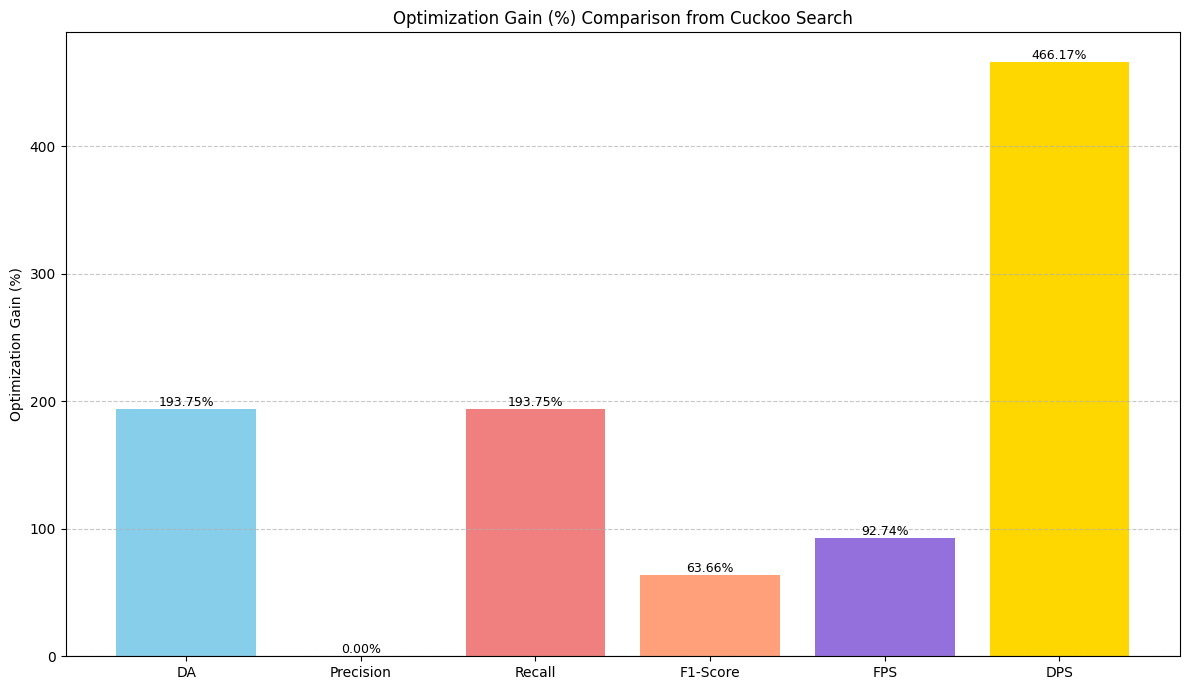


--- Generating Simplified Confusion Matrix Heatmap ---


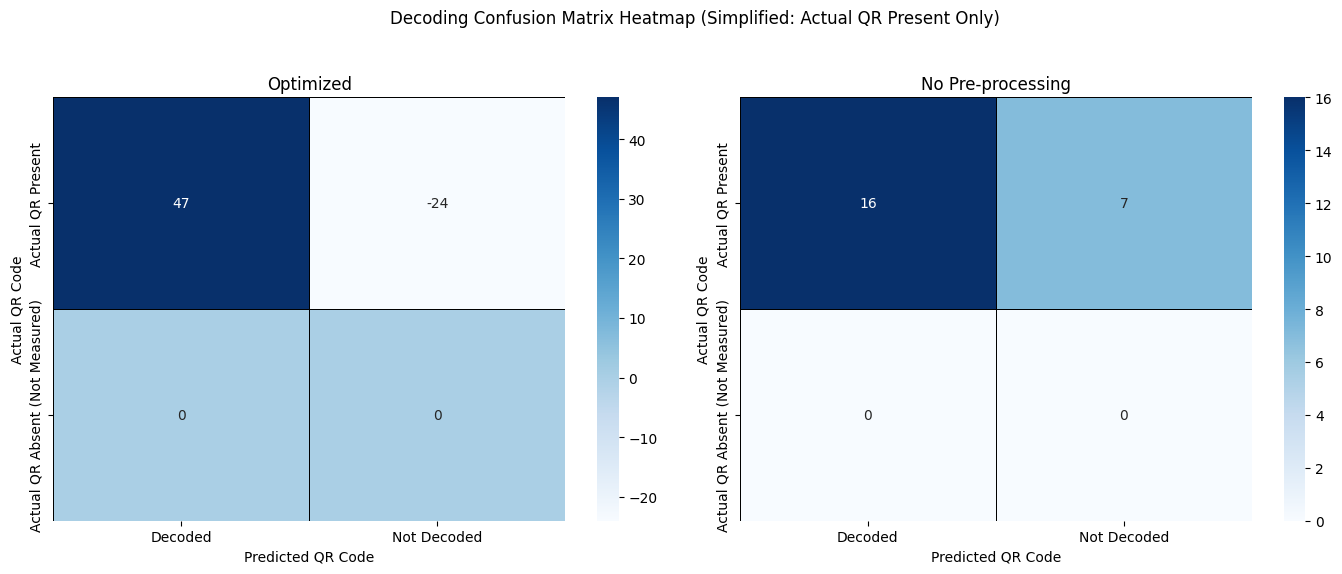


--- Attempting to generate Processing Time/FPS vs. Number of QR Codes Charts ---
NOTE: This requires knowledge of the EXACT number of QR codes in each image of the 'testmulti' dataset.
Please populate 'multi_qr_image_counts_gt' with the actual QR counts for your images for accurate plots.



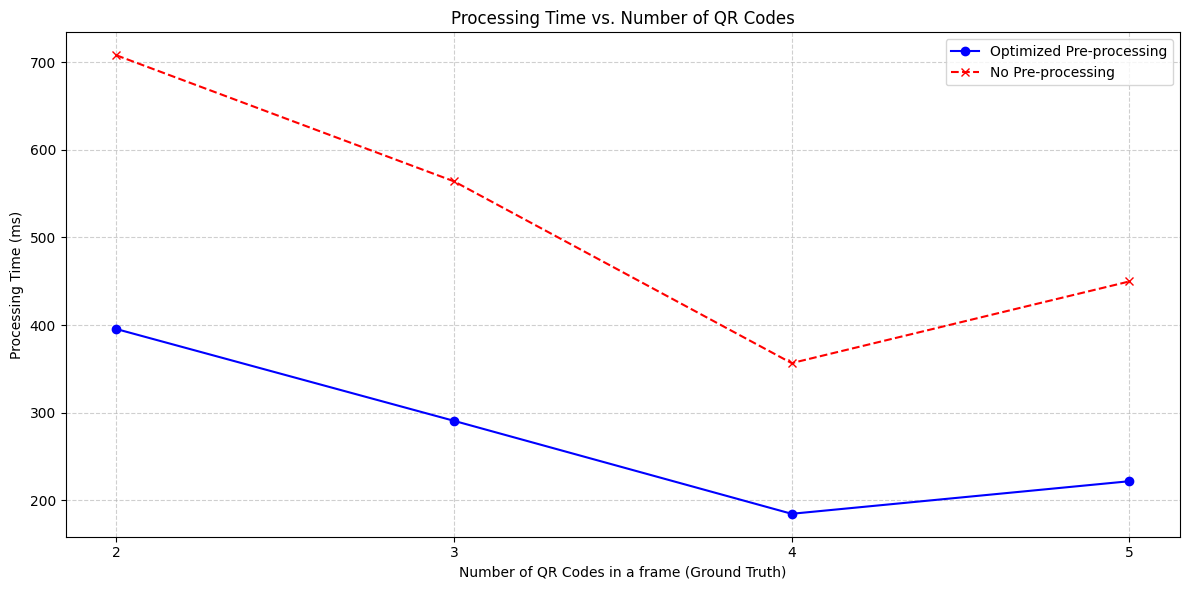

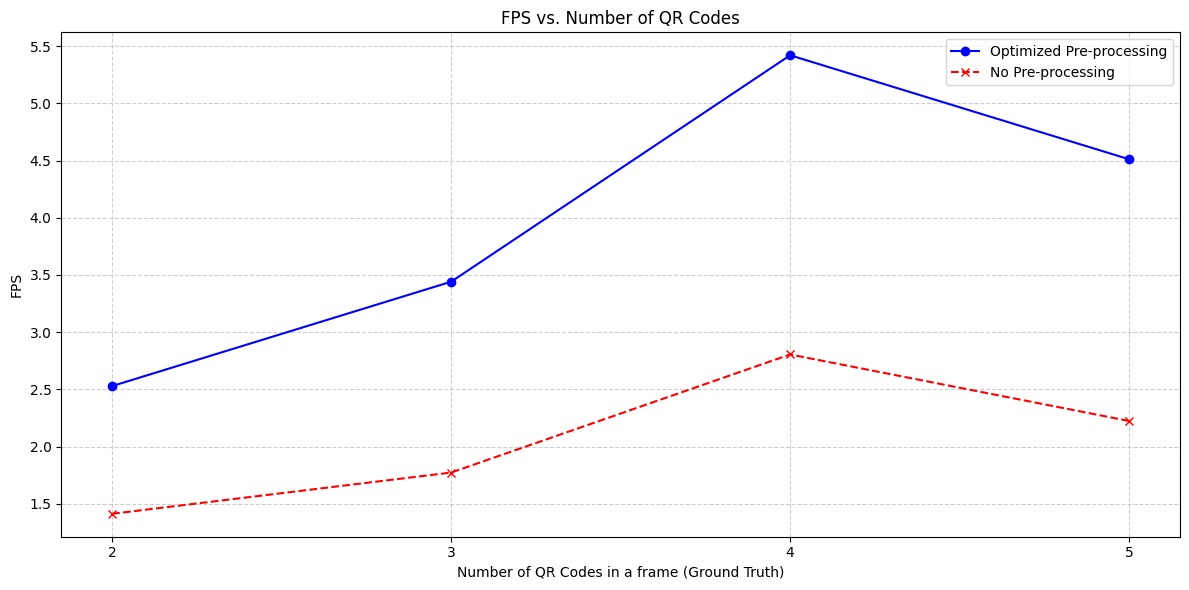


All performance metrics calculated and charts generated.


CS_Best_Fopt_Value,▁██████████████
CS_Initial_Best_Fopt,▁
CS_Iteration,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
Final_Metrics/NoOpt_DA_percent,▁
Final_Metrics/NoOpt_DPS,▁
Final_Metrics/NoOpt_F1_Score,▁
Final_Metrics/NoOpt_FPS,▁
Final_Metrics/NoOpt_MR_percent,▁
Final_Metrics/NoOpt_Precision,▁
Final_Metrics/NoOpt_Recall,▁
Final_Metrics/OG_DA_percent,▁


In [28]:
import numpy as np
import cv2
from pyzbar import pyzbar
import os
import glob
import time
import matplotlib.pyplot as plt
import pandas as pd # For tabular output
import seaborn as sns # For heatmap
import wandb # Assuming W&B is still desired

# --- W&B Setup ---
try:
    # Ensure you have logged in to W&B previously (e.g., via `wandb login` in your terminal)
    wandb.login()
    wandb.init(project="QR_Code_Decoding_Optimization", name="Cuckoo_Search_Fopt_Evaluation_v2") # Changed name for new run
    print("Weights & Biases initialized successfully.")
except Exception as e:
    print(f"Warning: Could not initialize Weights & Biases. Error: {e}")
    print("Metrics will only be printed to console.")
    # Create a dummy wandb object if initialization fails, to prevent errors
    class DummyWandB:
        def log(self, *args, **kwargs): pass
        def finish(self): pass
        config = {}
    wandb = DummyWandB()

# --- Pre-processing Function (Reusable) ---
def apply_preprocessing(image, blur_kernel_size, contrast_alpha, brightness_beta):
    """Applies pre-processing steps to an image."""
    processed_image = image.copy()

    # Grayscale conversion
    if len(processed_image.shape) == 3:
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)

    # Ensure kernel size is odd and positive for Gaussian blur
    blur_kernel_size = int(round(blur_kernel_size))
    if blur_kernel_size % 2 == 0:
        blur_kernel_size += 1
    blur_kernel_size = max(1, blur_kernel_size) # Minimum kernel size of 1

    # Gaussian Blur
    if blur_kernel_size > 0:
        processed_image = cv2.GaussianBlur(processed_image, (blur_kernel_size, blur_kernel_size), 0)

    # Contrast and Brightness Adjustment
    processed_image = cv2.convertScaleAbs(processed_image, alpha=contrast_alpha, beta=brightness_beta)
    return processed_image

# --- Define Dataset Paths ---
single_qr_image_dir = '/kaggle/input/ttestnew/image/'
multi_qr_image_dir = '/kaggle/input/testmulti/photo/'

# --- IMPORTANT: Provide your ground truth counts here for each dataset ---
# These values are CRUCIAL for accurate DA, MR, Precision, Recall, F1 calculation.
TRUE_TOTAL_QR_CODES_IN_SINGLE_QR_DATASET = 6 # As previously stated for ttestnew
# Placeholder: Please update this with the ACTUAL total number of QR codes in your /kaggle/input/testmulti/photo/ dataset.
TRUE_TOTAL_QR_CODES_IN_MULTI_QR_DATASET = 17 
# Sum of true QR codes in both datasets, used for the combined Fopt evaluation
TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION = TRUE_TOTAL_QR_CODES_IN_SINGLE_QR_DATASET + TRUE_TOTAL_QR_CODES_IN_MULTI_QR_DATASET

# Combine image file paths from both datasets for the Fopt evaluation
all_image_files = sorted(glob.glob(os.path.join(single_qr_image_dir, '*.jpg'))) + \
                  sorted(glob.glob(os.path.join(single_qr_image_dir, '*.png'))) + \
                  sorted(glob.glob(os.path.join(multi_qr_image_dir, '*.jpg'))) + \
                  sorted(glob.glob(os.path.join(multi_qr_image_dir, '*.png')))

if not all_image_files:
    print("Error: No image files found in either dataset directory. Please check paths and ensure datasets are mounted.")
    wandb.finish()
    exit()

print(f"Total images found for Fopt evaluation: {len(all_image_files)}")
print(f"Assumed TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION: {TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION}")


# --- Helper Function to Evaluate Pipeline and Calculate Metrics ---
def evaluate_pipeline_and_get_metrics(params, image_paths, true_total_qrs_gt):
    """
    Runs the pre-processing and decoding pipeline for given parameters
    and calculates various performance metrics (DA, FPS, DPS, MR, P, R, F1).
    """
    blur_kernel_size, contrast_alpha, brightness_beta = params

    total_images_processed = 0
    total_qrs_decoded_successfully = 0 # This will be our TP
    total_processing_time = 0.0

    # Ensure blur kernel is odd and positive before passing
    blur_kernel_size_safe = int(round(blur_kernel_size))
    if blur_kernel_size_safe % 2 == 0:
        blur_kernel_size_safe += 1
    blur_kernel_size_safe = max(1, blur_kernel_size_safe)


    for image_path in image_paths:
        original_image = cv2.imread(image_path)
        if original_image is None:
            # print(f"  Skipping unreadable image: {os.path.basename(image_path)}")
            continue # Skip unreadable images

        total_images_processed += 1
        start_time = time.time()

        processed_image = apply_preprocessing(original_image, blur_kernel_size_safe, contrast_alpha, brightness_beta)
        decoded_objects = pyzbar.decode(processed_image)

        if decoded_objects:
            total_qrs_decoded_successfully += len(decoded_objects)
        
        end_time = time.time()
        total_processing_time += (end_time - start_time)

    # Calculate metrics
    true_positives = total_qrs_decoded_successfully
    # False Negatives (FN): QRs in dataset that were NOT decoded
    false_negatives = true_total_qrs_gt - true_positives 
    
    # ASSUMPTION for False Positives (FP):
    # In this context, with pyzbar and a dataset expected to contain QRs,
    # a "false positive" would be pyzbar decoding something that isn't a QR or decoding
    # a completely different QR than what's actually present.
    # Given the robustness of pyzbar's checksums, false decodes are rare.
    # Also, we don't have images without QRs to explicitly count FPs.
    # Therefore, we assume 0 false positives for the calculation of P, R, F1.
    false_positives = 0 # This is the key assumption.

    # Detection Accuracy (DA) - as True Decoding Accuracy
    detection_accuracy_percent = (true_positives / true_total_qrs_gt) * 100 if true_total_qrs_gt > 0 else 0

    # Miss Rate (MR)
    miss_rate_percent = (false_negatives / true_total_qrs_gt) * 100 if true_total_qrs_gt > 0 else 0

    # Precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    # Recall (Synonymous with DA in this binary detection context where we only care about 'present' QRs)
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    # F1-Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Frames Per Second (FPS)
    avg_time_per_image = total_processing_time / total_images_processed if total_images_processed > 0 else 0
    fps = 1 / avg_time_per_image if avg_time_per_image > 0 else 0

    # Processing Time (Tp) - as Decodings Per Second (DPS)
    dps = true_positives / total_processing_time if total_processing_time > 0 else 0
    
    # Placeholder for IoU and FPR - these cannot be directly calculated with the current setup
    # as they require ground truth bounding box annotations and/or images without QR codes.
    iou_score = 0.0 # Not directly measurable with current ground truth
    false_positive_rate_fpr = 0.0 # Not directly measurable with current dataset (no negative samples)

    metrics = {
        "DA_percent": detection_accuracy_percent,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1_score,
        "FPS": fps,
        "DPS": dps, # Corresponds to Tp in mentor's table
        "MR_percent": miss_rate_percent,
        "IoU": iou_score, 
        "FPR": false_positive_rate_fpr,
        "TP_count": true_positives,
        "FN_count": false_negatives,
        "FP_count": false_positives, # Included with assumption
        "Total_Processing_Time": total_processing_time,
        "Total_Images_Processed": total_images_processed
    }
    return metrics

# --- Innovative Fitness Function for Optimization (Fopt) ---
# Fopt_adapted = w1*DA + w3*FPS - w4*MR (or using F1-score if preferred)
FOPT_WEIGHTS = {
    'w1': 1.0,  # Weight for Detection Accuracy (DA)
    'w3': 0.1,  # Weight for FPS
    'w4': 0.5   # Weight for Miss Rate (MR), penalizes misses
    # Consider using F1-score instead of DA for a balanced metric: 'w_f1': 1.0
}

def objective_function_fopt(parameters):
    """
    Calculates the adapted Fopt fitness value for a given set of pre-processing parameters.
    This function will be maximized by the Cuckoo Search algorithm.
    """
    metrics = evaluate_pipeline_and_get_metrics(parameters, all_image_files, TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION)
    
    da = metrics['DA_percent'] 
    fps = metrics['FPS']
    mr = metrics['MR_percent'] 
    # f1 = metrics['F1_Score'] # Could use F1 instead of DA if desired

    # Adapted Fopt calculation: Maximizing desired metrics, minimizing undesired.
    fopt_value = (FOPT_WEIGHTS['w1'] * da) + \
                 (FOPT_WEIGHTS['w3'] * fps) - \
                 (FOPT_WEIGHTS['w4'] * mr)
    
    # Print progress during optimization (can be verbose)
    # print(f"  [Fopt Objective] Params={np.round(parameters, 2)}, DA={da:.2f}%, FPS={fps:.2f}, MR={mr:.2f}%, Fopt={fopt_value:.4f}")
    
    return fopt_value

# --- Search Space for Image Pre-processing Optimization ---
image_prep_bounds = [
    (1, 11, 'int'),     # blur_kernel_size (must be odd and positive, handled in apply_preprocessing)
    (0.8, 3.0, 'float'), # contrast_alpha
    (-60, 60, 'int')    # brightness_beta (extended range slightly for better search)
]


# --- 2. Implement the Cuckoo Search Algorithm ---

def cuckoo_search(objective_func, search_space_bounds, num_nests=10, max_iterations=15, pa=0.25):
    """
    Generically implements the Cuckoo Search optimization algorithm.

    Args:
        objective_func (function): The function to optimize (maximize). It takes a
                                   list/array of parameters and returns a fitness value.
        search_space_bounds (list): A list of tuples, where each tuple defines the
                                    (min_val, max_val, type_hint) for a parameter.
                                    'type_hint' can be 'float' or 'int'.
        num_nests (int): The number of host nests (candidate solutions) in the population.
        max_iterations (int): The maximum number of iterations for the algorithm.
        pa (float): Probability that a host bird discovers a cuckoo egg (0.0 to 1.0).

    Returns:
        tuple: A tuple containing (best_nest, best_fitness), where best_nest is the
               optimized parameter set and best_fitness is its corresponding value.
    """
    dim = len(search_space_bounds) # Number of parameters to optimize

    # Initialize a population of host nests randomly within the search space bounds
    nests = np.zeros((num_nests, dim))
    for i in range(dim):
        min_val, max_val, param_type = search_space_bounds[i]
        nests[:, i] = np.random.uniform(min_val, max_val, num_nests)
        if param_type == 'int':
            nests[:, i] = np.round(nests[:, i])

    # Evaluate the fitness of initial nests
    print("Evaluating initial population...")
    fitness = np.array([objective_func(nest) for nest in nests])

    # Find the best nest and its fitness from the initial population
    best_nest_idx = np.argmax(fitness)
    best_nest = nests[best_nest_idx].copy()
    best_fitness = fitness[best_nest_idx]

    wandb.log({"CS_Initial_Best_Fopt": best_fitness, "CS_Initial_Best_Params": best_nest.tolist()})

    print("\nStarting Cuckoo Search Optimization...")

    for t in range(max_iterations):
        # Generate a new cuckoo egg (solution) using Levy flights
        sigma = (
            (np.random.gamma(1 + 1.5) * np.sin(np.pi * 1.5 / 2))
            / (np.random.gamma((1 + 1.5) / 2) * 1.5 * 2 ** ((1.5 - 1) / 2))
        ) ** (1 / 1.5) # Levy exponent beta = 1.5
        u = np.random.normal(0, sigma, dim)
        v = np.random.normal(0, 1, dim)
        step = u / (np.abs(v) ** (1 / 1.5)) # Levy flight step
        
        step_size_scalar = 0.01 * (best_nest - nests[np.random.randint(num_nests)])
        new_cuckoo = best_nest + step_size_scalar * step

        # Apply bounds and type conversion (e.g., integer rounding) to the new cuckoo egg
        for i, bounds in enumerate(search_space_bounds):
            min_val, max_val, param_type = bounds
            new_cuckoo[i] = max(min_val, min(new_cuckoo[i], max_val))
            if param_type == 'int':
                new_cuckoo[i] = np.round(new_cuckoo[i])

        new_cuckoo_fitness = objective_func(new_cuckoo)

        # Randomly choose a host nest from the current population
        j = np.random.randint(num_nests)

        # Compare new cuckoo egg with a random nest and replace if better (assuming maximization)
        if new_cuckoo_fitness > fitness[j]: 
            nests[j] = new_cuckoo
            fitness[j] = new_cuckoo_fitness

        # Abandon a fraction of worse nests (Pa) and build new ones at new random locations
        num_abandon = int(num_nests * pa)
        if num_abandon > 0:
            worse_nests_indices = np.argsort(fitness)[:num_abandon]
            for idx in worse_nests_indices:
                new_random_nest = np.zeros(dim)
                for i_dim, bounds in enumerate(search_space_bounds):
                    min_val, max_val, param_type = bounds
                    new_random_nest[i_dim] = np.random.uniform(min_val, max_val)
                    if param_type == 'int':
                        new_random_nest[i_dim] = np.round(new_random_nest[i_dim])
                nests[idx] = new_random_nest
                fitness[idx] = objective_func(new_random_nest)

        # Update the global best solution found so far
        current_best_idx = np.argmax(fitness)
        if fitness[current_best_idx] > best_fitness:
            best_nest = nests[current_best_idx].copy()
            best_fitness = fitness[current_best_idx]

        print(f"Iteration {t+1}/{max_iterations}: Current Best Fopt = {best_fitness:.4f}, Best Params = {np.round(best_nest, 2)}")
        wandb.log({"CS_Iteration": t+1, "CS_Best_Fopt_Value": best_fitness, "CS_Best_Params": best_nest.tolist()})

    print("\nCuckoo Search Optimization Complete.")
    return best_nest, best_fitness

# --- Run Cuckoo Search for Image Pre-processing Optimization ---
print("\n--- Running Cuckoo Search for Image Pre-processing Optimization (using adapted Fopt) ---")
best_img_prep_params, best_fopt_fitness = cuckoo_search(
    objective_function_fopt,
    image_prep_bounds,
    num_nests=10,       # Number of candidate solutions
    max_iterations=15   # Number of optimization steps
)

optimized_params_list = best_img_prep_params.tolist()
print(f"\nOptimized Image Pre-processing Parameters Found: {optimized_params_list}")
print(f"Corresponding Fopt Fitness Score: {best_fopt_fitness:.4f}")

wandb.config.final_optimized_params = optimized_params_list
wandb.config.final_fopt_fitness = best_fopt_fitness

# --- Final Performance Evaluation and Metrics Output ---

# 1. Evaluate with Optimized Parameters
print("\n--- Final Evaluation: Optimized Pre-processing ---")
final_optimized_metrics = evaluate_pipeline_and_get_metrics(
    optimized_params_list,
    all_image_files, # Evaluate on the combined dataset used for optimization
    TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION
)

# 2. Evaluate with No Pre-processing (Baseline)
print("\n--- Final Evaluation: No Pre-processing (Baseline) ---")
no_preprocessing_params = [1.0, 1.0, 0.0] # Blur=1 (no effect), Contrast=1, Brightness=0
final_no_opt_metrics = evaluate_pipeline_and_get_metrics(
    no_preprocessing_params,
    all_image_files, # Evaluate on the combined dataset
    TRUE_TOTAL_QR_CODES_FOR_FOPT_EVALUATION
)

# --- Tabular Representation of Performance Parameters ---
print("\n--- Tabular Representation of Performance Parameters ---")

# Calculate Optimization Gain (OG) for each relevant metric
def calculate_optimization_gain(optimized_val, baseline_val):
    if baseline_val == 0 and optimized_val > 0: # If baseline is 0 but optimized improved, return infinity
        return np.inf
    elif baseline_val == 0 and optimized_val == 0: # If both are 0, no gain
        return 0.0
    return ((optimized_val - baseline_val) / baseline_val) * 100

og_da = calculate_optimization_gain(final_optimized_metrics['DA_percent'], final_no_opt_metrics['DA_percent'])
og_precision = calculate_optimization_gain(final_optimized_metrics['Precision'], final_no_opt_metrics['Precision'])
og_recall = calculate_optimization_gain(final_optimized_metrics['Recall'], final_no_opt_metrics['Recall'])
og_f1 = calculate_optimization_gain(final_optimized_metrics['F1_Score'], final_no_opt_metrics['F1_Score'])
og_fps = calculate_optimization_gain(final_optimized_metrics['FPS'], final_no_opt_metrics['FPS'])
og_dps = calculate_optimization_gain(final_optimized_metrics['DPS'], final_no_opt_metrics['DPS'])


metrics_data = {
    "Metric": [
        "Detection Accuracy (DA) %",
        "Precision",
        "Recall",
        "F1-Score",
        "Miss Rate (MR) %",
        "Processing Time (Tp - DPS)",
        "Frames Per Second (FPS)",
        "IoU Score", # N/A
        "False Positive Rate (FPR)", # N/A
    ],
    "Optimized Value": [
        f"{final_optimized_metrics['DA_percent']:.2f}",
        f"{final_optimized_metrics['Precision']:.4f}",
        f"{final_optimized_metrics['Recall']:.4f}",
        f"{final_optimized_metrics['F1_Score']:.4f}",
        f"{final_optimized_metrics['MR_percent']:.2f}",
        f"{final_optimized_metrics['DPS']:.2f}",
        f"{final_optimized_metrics['FPS']:.2f}",
        "N/A", # IoU
        "N/A", # FPR
    ],
    "No Pre-processing Value": [
        f"{final_no_opt_metrics['DA_percent']:.2f}",
        f"{final_no_opt_metrics['Precision']:.4f}",
        f"{final_no_opt_metrics['Recall']:.4f}",
        f"{final_no_opt_metrics['F1_Score']:.4f}",
        f"{final_no_opt_metrics['MR_percent']:.2f}",
        f"{final_no_opt_metrics['DPS']:.2f}",
        f"{final_no_opt_metrics['FPS']:.2f}",
        "N/A", # IoU
        "N/A", # FPR
    ]
}

df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.to_string(index=False))

print("\n--- Optimization Gain (OG) ---")
print(f"  DA Optimization Gain: {og_da:.2f}%")
print(f"  Precision Optimization Gain: {og_precision:.2f}%")
print(f"  Recall Optimization Gain: {og_recall:.2f}%")
print(f"  F1-Score Optimization Gain: {og_f1:.2f}%")
print(f"  FPS Optimization Gain: {og_fps:.2f}%")
print(f"  DPS (Tp) Optimization Gain: {og_dps:.2f}%")


# Log final metrics to W&B
wandb.log({
    "Final_Metrics/Optimized_DA_percent": final_optimized_metrics['DA_percent'],
    "Final_Metrics/Optimized_Precision": final_optimized_metrics['Precision'],
    "Final_Metrics/Optimized_Recall": final_optimized_metrics['Recall'],
    "Final_Metrics/Optimized_F1_Score": final_optimized_metrics['F1_Score'],
    "Final_Metrics/Optimized_MR_percent": final_optimized_metrics['MR_percent'],
    "Final_Metrics/Optimized_DPS": final_optimized_metrics['DPS'],
    "Final_Metrics/Optimized_FPS": final_optimized_metrics['FPS'],
    "Final_Metrics/NoOpt_DA_percent": final_no_opt_metrics['DA_percent'],
    "Final_Metrics/NoOpt_Precision": final_no_opt_metrics['Precision'],
    "Final_Metrics/NoOpt_Recall": final_no_opt_metrics['Recall'],
    "Final_Metrics/NoOpt_F1_Score": final_no_opt_metrics['F1_Score'],
    "Final_Metrics/NoOpt_MR_percent": final_no_opt_metrics['MR_percent'],
    "Final_Metrics/NoOpt_DPS": final_no_opt_metrics['DPS'],
    "Final_Metrics/NoOpt_FPS": final_no_opt_metrics['FPS'],
    "Final_Metrics/OG_DA_percent": og_da,
    "Final_Metrics/OG_Precision_percent": og_precision,
    "Final_Metrics/OG_Recall_percent": og_recall,
    "Final_Metrics/OG_F1_percent": og_f1,
    "Final_Metrics/OG_FPS_percent": og_fps,
    "Final_Metrics/OG_DPS_percent": og_dps,
})


# --- Graphical Representations ---

# 1. Optimization Gain (%) Comparison (Bar Chart)
print("\n--- Generating Optimization Gain (%) Comparison Chart ---")
og_labels = ['DA', 'Precision', 'Recall', 'F1-Score', 'FPS', 'DPS']
og_values = [og_da, og_precision, og_recall, og_f1, og_fps, og_dps]

plt.figure(figsize=(12, 7))
bars = plt.bar(og_labels, og_values, color=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'mediumpurple', 'gold'])
plt.ylabel('Optimization Gain (%)')
plt.title('Optimization Gain (%) Comparison from Cuckoo Search')
plt.axhline(0, color='grey', linewidth=0.8) # Add a zero line
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom' if yval >= 0 else 'top', fontsize=9)

plt.tight_layout()
wandb.log({"Optimization_Gain_Chart": wandb.Image(plt)})
plt.show()
plt.close()


# 2. Simplified Confusion Matrix Heatmap (for Decoding Success/Failure)
print("\n--- Generating Simplified Confusion Matrix Heatmap ---")

# Data for Confusion Matrix for Optimized vs No Pre-processing
metrics_for_confusion = {
    'Optimized': {
        'TP': final_optimized_metrics['TP_count'],
        'FN': final_optimized_metrics['FN_count'],
        'FP': final_optimized_metrics['FP_count'] # This will be 0 due to assumption
    },
    'No Pre-processing': {
        'TP': final_no_opt_metrics['TP_count'],
        'FN': final_no_opt_metrics['FN_count'],
        'FP': final_no_opt_metrics['FP_count'] # This will be 0 due to assumption
    }
}

# Create two subplots for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Decoding Confusion Matrix Heatmap (Simplified: Actual QR Present Only)')

for i, (label, data) in enumerate(metrics_for_confusion.items()):
    tp = data['TP']
    fn = data['FN']
    fp = data['FP'] # This is 0 based on our assumption

    # For visualization purposes, we can represent it as 2x2,
    # acknowledging the limitations of FP/TN in this context.
    # True Negative (TN) is also effectively 0 as we have no images without QRs.
    confusion_matrix_data = np.array([
        [tp, fp],  # Row 1: Actual Positive (QR Present) -> Predicted Positive (Decoded), Predicted Negative (False Positive - assumed 0)
        [fn, 0]    # Row 2: Actual Negative (QR Absent - but this row is for *actual* QRs not decoded, so this is FN, TN is not applicable here)
                   # For clarity in standard confusion matrix:
                   # [TP, FP]
                   # [FN, TN]
                   # Our context: TP (decoded), FN (not decoded but present), FP (non-QR decoded - assumed 0), TN (no-QR not decoded - no data)
    ])

    # Re-arranging for a more intuitive standard confusion matrix layout, acknowledging limitations:
    #                 Predicted Positive | Predicted Negative
    # Actual Positive       TP               |      FN
    # Actual Negative       FP               |      TN (not measurable)
    
    # Since we are focusing on *decoding success from images with QRs*:
    # Predicted Decoded | Predicted Not Decoded
    # Actual QR Present     TP             |      FN
    # (Actual QR Absent)    (FP=0)         |      (TN=0)

    # Simplified representation for heatmap, only showing relevant cells
    heatmap_matrix = np.array([
        [tp, fn], # First row: Actual QRs (TP decoded, FN not decoded)
        [0, 0]    # Second row: Representing Actual Absent, with FP and TN (set to 0 due to data limitations)
    ])
    
    xticklabels = ['Decoded', 'Not Decoded']
    yticklabels = ['Actual QR Present', 'Actual QR Absent (Not Measured)'] # Label explicitly for clarity


    sns.heatmap(heatmap_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=xticklabels,
                yticklabels=yticklabels,
                ax=axes[i],
                linewidths=.5, linecolor='black') 
    axes[i].set_title(label)
    axes[i].set_xlabel('Predicted QR Code')
    axes[i].set_ylabel('Actual QR Code')
    axes[i].tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
wandb.log({"Decoding_Confusion_Matrix": wandb.Image(plt)})
plt.show()
plt.close()


# 3. Processing Time vs. Number of QR Codes (and FPS vs. Number of QR Codes)
print("\n--- Attempting to generate Processing Time/FPS vs. Number of QR Codes Charts ---")
print("NOTE: This requires knowledge of the EXACT number of QR codes in each image of the 'testmulti' dataset.")
print("Please populate 'multi_qr_image_counts_gt' with the actual QR counts for your images for accurate plots.")

# For this to work accurately, we need the true QR count per image in the multi-QR dataset.
# The 'multi_qr_image_counts_gt' dictionary below is a PLACEHOLDER.
# You MUST replace the example values with the ACTUAL ground truth QR count for each image filename.
multi_qr_image_counts_gt = {
    '8.jpg': 1,
    '9.jpg': 2,
    '10.jpg': 2,
    '11.jpg': 2,
    '12.jpg': 2,
    '13.jpg': 3,
    '14.jpg': 3,
    '15.jpg': 3,
    '16.jpg': 3,
    '17.jpg': 4,
    '18.jpg': 4,
    '19.jpg': 4,
    '20.jpg': 4,
    '21.jpg': 5,
    '22.jpg': 5,
    '23.jpg': 5,
    '24.jpg': 5,
    # Add all other images from /kaggle/input/testmulti/photo/ and their actual QR counts here
}

# Data structures to aggregate performance metrics by actual QR code count
qr_counts_opt_processing_times = {} # {qr_count: [time1, time2, ...]}
qr_counts_opt_decoded_counts = {}   # {qr_count: [decoded_count1, decoded_count2, ...]}

qr_counts_no_opt_processing_times = {}
qr_counts_no_opt_decoded_counts = {}


def process_dataset_for_density_plot(image_dir, params, qr_counts_gt_map, plot_data_time, plot_data_decoded):
    local_image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg'))) + \
                        sorted(glob.glob(os.path.join(image_dir, '*.png')))
    
    for img_path in local_image_files:
        img_name = os.path.basename(img_path)
        actual_qr_count = qr_counts_gt_map.get(img_name, None)

        if actual_qr_count is None:
            continue # Skip if we don't know the actual count

        original_image = cv2.imread(img_path)
        if original_image is None:
            continue

        start_time = time.time()
        processed_image = apply_preprocessing(original_image, *params)
        decoded_objects = pyzbar.decode(processed_image)
        end_time = time.time()
        
        processing_time_ms = (end_time - start_time) * 1000 # Convert to milliseconds

        if actual_qr_count not in plot_data_time:
            plot_data_time[actual_qr_count] = []
            plot_data_decoded[actual_qr_count] = []
        
        plot_data_time[actual_qr_count].append(processing_time_ms)
        plot_data_decoded[actual_qr_count].append(len(decoded_objects))


# Process both optimization scenarios for the multi_qr_image_dir
print("\nCollecting data for density plots (Optimized Pre-processing)...")
process_dataset_for_density_plot(multi_qr_image_dir, optimized_params_list, multi_qr_image_counts_gt,
                                 qr_counts_opt_processing_times, qr_counts_opt_decoded_counts)

print("Collecting data for density plots (No Pre-processing)...")
process_dataset_for_density_plot(multi_qr_image_dir, no_preprocessing_params, multi_qr_image_counts_gt,
                                 qr_counts_no_opt_processing_times, qr_counts_no_opt_decoded_counts)


# Prepare data for plotting
if qr_counts_opt_processing_times and qr_counts_no_opt_processing_times:
    # Get all unique QR counts observed
    qr_counts_all = sorted(list(set(qr_counts_opt_processing_times.keys()) | set(qr_counts_no_opt_processing_times.keys())))

    # Calculate average times for each QR count category
    avg_opt_times = [np.mean(qr_counts_opt_processing_times.get(qc, [0])) for qc in qr_counts_all]
    avg_no_opt_times = [np.mean(qr_counts_no_opt_processing_times.get(qc, [0])) for qc in qr_counts_all]

    # Calculate average FPS for each QR count category (FPS = 1000ms / Avg Time in ms)
    avg_opt_fps = [1000 / avg_time if avg_time > 0 else 0 for avg_time in avg_opt_times]
    avg_no_opt_fps = [1000 / avg_time if avg_time > 0 else 0 for avg_time in avg_no_opt_times]

    # Plot Processing Time vs. Number of QR Codes
    plt.figure(figsize=(12, 6))
    plt.plot(qr_counts_all, avg_opt_times, marker='o', linestyle='-', label='Optimized Pre-processing', color='blue')
    plt.plot(qr_counts_all, avg_no_opt_times, marker='x', linestyle='--', label='No Pre-processing', color='red')
    plt.xlabel('Number of QR Codes in a frame (Ground Truth)')
    plt.ylabel('Processing Time (ms)')
    plt.title('Processing Time vs. Number of QR Codes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(qr_counts_all) # Ensure X-axis ticks match the actual QR counts
    plt.tight_layout()
    wandb.log({"Processing_Time_vs_QR_Count": wandb.Image(plt)})
    plt.show()
    plt.close()

    # Plot FPS vs. Number of QR Codes
    plt.figure(figsize=(12, 6))
    plt.plot(qr_counts_all, avg_opt_fps, marker='o', linestyle='-', label='Optimized Pre-processing', color='blue')
    plt.plot(qr_counts_all, avg_no_opt_fps, marker='x', linestyle='--', label='No Pre-processing', color='red')
    plt.xlabel('Number of QR Codes in a frame (Ground Truth)')
    plt.ylabel('FPS')
    plt.title('FPS vs. Number of QR Codes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(qr_counts_all) # Ensure X-axis ticks match the actual QR counts
    plt.tight_layout()
    wandb.log({"FPS_vs_QR_Count": wandb.Image(plt)})
    plt.show()
    plt.close()

else:
    print("Not enough data with ground truth QR counts to generate Processing Time/FPS vs. Number of QR Codes charts.")
    print("Please ensure 'multi_qr_image_counts_gt' is accurately populated for images in the multi-QR dataset.")


print("\nAll performance metrics calculated and charts generated.")
wandb.finish()